In [1]:
# %%capture
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu121.html
!pip install pandas numpy torch torch_geometric networkx matplotlib

print("installtion complete")

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00a 0:00:01
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.0 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.6/991.6 kB 33.0 MB/s eta 0:00:00
installtion complete


In [2]:
# !pip install --no-binary=torch-sparse torch-sparse
# pip install --no-binary=torch-scatter torch-scatter

In [3]:
import warnings
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from datetime import datetime
from tqdm import tqdm
import warnings
import os
from sklearn.metrics import confusion_matrix,roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt



from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx
# from torch_geometric.loader import ClusterData, ClusterLoader, NeighborLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch_geometric.loader import HGTLoader, ImbalancedSampler

In [16]:
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

Using device: cuda


# Model Class

In [18]:
# TemporalEncoding
class TemporalEncoding(nn.Module):
    def __init__(self, d_model=64, max_len=10000):
        super(TemporalEncoding, self).__init__()
        self.d_model = d_model
        self.div_term_sin = torch.exp(torch.arange(1, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)).to(device)
        self.div_term_cos = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)).to(device)
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, timestamps):  # Change here: accept timestamps directly
        #timestamps = torch.tensor([datetime.strptime(date, "%Y-%m-%d").timestamp() for date in dates], dtype=torch.float, device=device)  # Remove this line

        # timestamps should already be a tensor, check and convert if needed
        if not isinstance(timestamps, torch.Tensor):
            timestamps = torch.tensor(timestamps, dtype=torch.float, device=device)

        pe = torch.zeros(timestamps.size(0), self.d_model, device=device)
        position = timestamps.unsqueeze(1)
        pe[:, 1::2] = torch.sin(position * self.div_term_sin)
        pe[:, 0::2] = torch.cos(position * self.div_term_cos)
        return self.linear(pe)

class STAGT(nn.Module):
    def __init__(self, in_channels_transaction=8, in_channels_user=31, hidden_channels=64, out_channels=2, edge_types=None, num_layers=2, num_heads=4):
        super(STAGT, self).__init__()
        if edge_types is None:
            edge_types = [('user', 'sends', 'transaction'), ('transaction', 'received_by', 'user')]

        self.edge_types = edge_types
        self.num_relations = len(edge_types)

        # Initial embeddings
        self.initial_embed_transaction = nn.Linear(in_channels_transaction, hidden_channels)
        self.initial_embed_user = nn.Linear(in_channels_user, hidden_channels)
        self.temporal_enc = TemporalEncoding(hidden_channels)

        # GNN layers with relation-specific convolutions
        self.gnn_layers = nn.ModuleList()
        self.attention_weights = nn.ModuleList()  # For relation-level attention parameters
        for i in range(num_layers):
            conv_dict = {
                edge_type: SAGEConv(hidden_channels if i == 0 else hidden_channels, hidden_channels)
                for edge_type in edge_types
            }
            self.gnn_layers.append(HeteroConv(conv_dict))
            # Register attention parameters for each layer
            q = nn.Parameter(torch.randn(hidden_channels))
            b = nn.Parameter(torch.zeros(hidden_channels))
            W = nn.Linear(hidden_channels, hidden_channels)
            self.register_parameter(f'q_{i}', q)
            self.register_parameter(f'b_{i}', b)
            self.attention_weights.append(nn.ModuleDict({'W': W}))

        # Transformer and MLP
        d_model = hidden_channels * num_layers
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=1)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.num_layers = num_layers

    def compute_relation_attention(self, x_dict, layer_idx):
        # Compute attention scores for each relation
        attention_scores = []
        for edge_type in self.edge_types:
            h = x_dict['transaction']  # Focus on transaction nodes as targets
            q = getattr(self, f'q_{layer_idx}')
            b = getattr(self, f'b_{layer_idx}')
            W = self.attention_weights[layer_idx]['W']

            # Compute attention score: q^T * tanh(W * h + b)
            transformed = torch.tanh(W(h) + b)
            score = torch.mean(q @ transformed.T, dim=-1)  # Average over nodes
            attention_scores.append(score)

        # Softmax over relation scores
        attention_scores = torch.stack(attention_scores)
        alpha = F.softmax(attention_scores, dim=0)  # Shape: [num_relations]
        return alpha

    def forward(self, data):
        x_dict = {
            'transaction': data['transaction'].x,
            'user': data['user'].x
        }
        edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in self.edge_types}
        dates = data['transaction'].date

        # Initial embeddings
        h_transaction = F.relu(self.initial_embed_transaction(x_dict['transaction']))
        h_user = F.relu(self.initial_embed_user(x_dict['user']))
        temporal_emb = self.temporal_enc(dates)
        h_transaction = h_transaction + temporal_emb

        x_dict = {'transaction': h_transaction, 'user': h_user}
        inter_layer_embeds = []

        # GNN layers with relation-level attention
        for layer_idx, layer in enumerate(self.gnn_layers):
            # Apply convolution for each relation
            x_dict = layer(x_dict, edge_index_dict)
            h_transaction_per_relation = []

            # Collect transaction embeddings per relation
            for edge_type in self.edge_types:
                h_transaction_per_relation.append(x_dict['transaction'])
            # Compute attention weights
            alpha = self.compute_relation_attention(x_dict, layer_idx)
            # print(alpha)
            # Combine transaction embeddings with attention weights
            h_transaction_combined = torch.zeros_like(h_transaction_per_relation[0])
            for r, h_r in enumerate(h_transaction_per_relation):
                # print(f"for {r = }: {h_r = } and {alpha[r] = }")
                h_transaction_combined += alpha[r] * F.relu(h_r)

            # x_dict['transaction'] = h_transaction_combined
            inter_layer_embeds.append(h_transaction_combined)

        
        # Interlayer fusion
        h = torch.cat(inter_layer_embeds, dim=-1)
        # print(f"{h.shape = }")
        # print(f"{h.shape = }")
        # Transformer and MLP
        h = h.unsqueeze(1).contiguous()
        h = self.transformer(h)
        h = h.squeeze(1)
        out = self.mlp(h)
        return out

In [19]:
# # TemporalEncoding
# class TemporalEncoding(nn.Module):
#     def __init__(self, d_model=64, max_len=10000):
#         super(TemporalEncoding, self).__init__()
#         self.d_model = d_model
#         self.div_term_sin = torch.exp(torch.arange(1, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)).to(device)
#         self.div_term_cos = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)).to(device)
#         self.linear = nn.Linear(d_model, d_model)

#     def forward(self, timestamps):  # Change here: accept timestamps directly
#         #timestamps = torch.tensor([datetime.strptime(date, "%Y-%m-%d").timestamp() for date in dates], dtype=torch.float, device=device)  # Remove this line

#         # timestamps should already be a tensor, check and convert if needed
#         if not isinstance(timestamps, torch.Tensor):
#             timestamps = torch.tensor(timestamps, dtype=torch.float, device=device)

#         pe = torch.zeros(timestamps.size(0), self.d_model, device=device)
#         position = timestamps.unsqueeze(1)
#         pe[:, 1::2] = torch.sin(position * self.div_term_sin)
#         pe[:, 0::2] = torch.cos(position * self.div_term_cos)
#         return self.linear(pe)

# class STAGT(nn.Module):
#     def __init__(self, in_channels_transaction=8, in_channels_user=31, hidden_channels=64, out_channels=2, edge_types=None, num_layers=2, num_heads=4):
#         super(STAGT, self).__init__()
#         if edge_types is None:
#             edge_types = [('user', 'sends', 'transaction'), ('transaction', 'received_by', 'user')]

#         self.edge_types = edge_types
#         self.num_relations = len(edge_types)

#         # Initial embeddings
#         self.initial_embed_transaction = nn.Linear(in_channels_transaction, hidden_channels)
#         self.initial_embed_user = nn.Linear(in_channels_user, hidden_channels)
#         self.temporal_enc = TemporalEncoding(hidden_channels)

#         # GNN layers with relation-specific convolutions
#         self.gnn_layers = nn.ModuleList()
#         for i in range(num_layers):
#             conv_dict = {
#                 edge_type: SAGEConv(hidden_channels if i == 0 else hidden_channels, hidden_channels)
#                 for edge_type in edge_types
#             }
#             self.gnn_layers.append(HeteroConv(conv_dict))

#         # Transformer and MLP
#         d_model = hidden_channels * num_layers
#         encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)
#         self.transformer = TransformerEncoder(encoder_layer, num_layers=1)
#         self.mlp = nn.Sequential(
#             nn.Linear(d_model, hidden_channels // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_channels // 2, out_channels)
#         )
#         self.num_layers = num_layers

#     def forward(self, data):
#         x_dict = {
#             'transaction': data['transaction'].x,
#             'user': data['user'].x
#         }
#         edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in self.edge_types}
#         dates = data['transaction'].date

#         # Initial embeddings
#         h_transaction = F.relu(self.initial_embed_transaction(x_dict['transaction']))
#         h_user = F.relu(self.initial_embed_user(x_dict['user']))
#         temporal_emb = self.temporal_enc(dates)
#         h_transaction = h_transaction + temporal_emb

#         x_dict = {'transaction': h_transaction, 'user': h_user}
#         inter_layer_embeds = []

#         # GNN layers without relation-level attention
#         for layer in self.gnn_layers:
#             # Apply convolution for each relation
#             x_dict = layer(x_dict, edge_index_dict)
#             # Average transaction embeddings across relations
#             h_transaction_combined = x_dict['transaction']  # HeteroConv returns a single transaction embedding
#             inter_layer_embeds.append(h_transaction_combined)

#         # Interlayer fusion
#         h = torch.cat(inter_layer_embeds, dim=-1)
#         # Transformer and MLP
#         h = h.unsqueeze(1).contiguous()
#         h = self.transformer(h)
#         h = h.squeeze(1)
#         out = self.mlp(h)
#         return out

In [20]:
# Main execution
# dataset = HetroGraphDataset('/kaggle/input/complete-dataset/data.csv', graph_path='/kaggle/input/complete-graph/complete-graph.pt', force_recreate=False)  # Force recreate to update features
data = torch.load("/kaggle/input/graph-dataset/graph.pt")
# data = dataset.graph
data = data.to(device)

# Verify feature shapes
print(f"Transaction features shape: {data['transaction'].x.shape}")
print(f"User features shape: {data['user'].x.shape}")

Transaction features shape: torch.Size([157968, 8])
User features shape: torch.Size([148261, 31])


In [21]:
# Convert all relevant attributes to tensors
for node_type in data.node_types:
    if 'x' in data[node_type]:
        if isinstance(data[node_type].x, list):
            data[node_type].x = torch.tensor(np.array(data[node_type].x, dtype=np.float32), device=device)
        data[node_type].x = data[node_type].x.to(device)
    if 'is_laundering' in data[node_type]:
        if isinstance(data[node_type].is_laundering, list):
            data[node_type].is_laundering = torch.tensor(data[node_type].is_laundering, dtype=torch.long, device=device)
        data[node_type].is_laundering = data[node_type].is_laundering.to(device)
    if 'date' in data[node_type]:
        if isinstance(data[node_type].date, list):
            dates = data[node_type].date
            dates_dt = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
            timestamps = torch.tensor([date.timestamp() for date in dates_dt], dtype=torch.float32, device=device)
            data[node_type].date = timestamps
        data[node_type].date = data[node_type].date.to(device)
for edge_type in data.edge_types:
    data[edge_type].edge_index = data[edge_type].edge_index.to(device)

# Count labels in full dataset
labels = data['transaction'].is_laundering.to(dtype=torch.long, device=device)
num_label_0_full = (labels == 0).sum().item()
num_label_1_full = (labels == 1).sum().item()
print(f"Full dataset - Label 0 (legitimate): {num_label_0_full}, Label 1 (fraudulent): {num_label_1_full}")
print(f"Total transactions: {num_label_0_full + num_label_1_full}")

# Time-based split for 70% train, 30% test
timestamps = data['transaction'].date  # Now a tensor
if not isinstance(timestamps, torch.Tensor):  # Fallback if still not a tensor
    dates = timestamps
    dates_dt = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    timestamps = torch.tensor([date.timestamp() for date in dates_dt], dtype=torch.float32, device=device)
    data['transaction'].date = timestamps
sorted_indices = torch.argsort(timestamps)
num_transactions = len(timestamps)
train_size = int(0.7 * num_transactions)
train_indices = sorted_indices[:train_size]
train_mask = torch.zeros(num_transactions, dtype=torch.bool, device=device)
train_mask[train_indices] = True
test_mask = ~train_mask

data['transaction'].train_mask = train_mask
data['transaction'].test_mask = test_mask

# Count labels in train and test sets
labels_train = labels[train_mask]
labels_test = labels[test_mask]
num_label_0_train = (labels_train == 0).sum().item()
num_label_1_train = (labels_train == 1).sum().item()
num_label_0_test = (labels_test == 0).sum().item()
num_label_1_test = (labels_test == 1).sum().item()
print(f"Training set - Label 0: {num_label_0_train}, Label 1: {num_label_1_train}")
print(f"Testing set - Label 0: {num_label_0_test}, Label 1: {num_label_1_test}")

# Calculate class weights based on training set
total_train_samples = num_label_0_train + num_label_1_train
weight_class_0 = total_train_samples / num_label_0_train if num_label_0_train > 0 else 1
weight_class_1 = total_train_samples / num_label_1_train if num_label_1_train > 0 else 1
class_weights = torch.tensor([weight_class_0, weight_class_1], dtype=torch.float32, device=device)
print(f"Calculated class weights - Class 0: {weight_class_0:.4f}, Class 1: {weight_class_1:.4f}")

Full dataset - Label 0 (legitimate): 148095, Label 1 (fraudulent): 9873
Total transactions: 157968
Training set - Label 0: 103836, Label 1: 6741
Testing set - Label 0: 44259, Label 1: 3132
Calculated class weights - Class 0: 1.0649, Class 1: 16.4036


In [28]:

hgt_loader = HGTLoader(
    data,
    input_nodes='transaction',  # Focus on transaction nodes (target for fraud detection)
    num_samples=[2048,2048],       
    batch_size=4096,             
    shuffle=True,
    num_workers=0          
)

# Model setup
edge_types = [('user', 'sends', 'transaction'), ('transaction', 'received_by', 'user')]
model = STAGT(
    in_channels_transaction=8,
    in_channels_user=31,
    hidden_channels=64,
    out_channels=2,
    edge_types=edge_types,
    num_layers=2,
    num_heads=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [29]:
model

STAGT(
  (initial_embed_transaction): Linear(in_features=8, out_features=64, bias=True)
  (initial_embed_user): Linear(in_features=31, out_features=64, bias=True)
  (temporal_enc): TemporalEncoding(
    (linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (gnn_layers): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=2)
  )
  (attention_weights): ModuleList(
    (0-1): 2 x ModuleDict(
      (W): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
       

Training batches: 100%|██████████| 39/39 [00:01<00:00, 28.09it/s]


Epoch 1/200, Loss: 0.6727


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.57it/s]


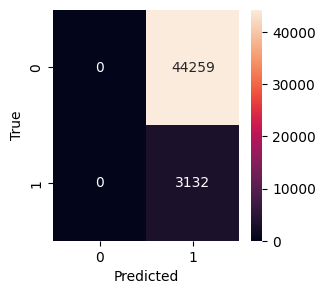

Test - Recall: 1.0000, F1: 0.1240, Accuracy: 0.0661
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 28.02it/s]


Epoch 2/200, Loss: 0.5963


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.31it/s]


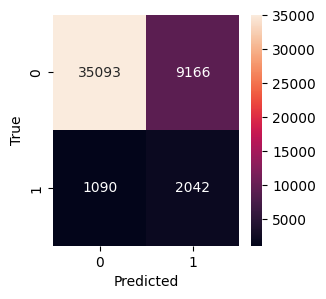

Test - Recall: 0.6520, F1: 0.2848, Accuracy: 0.7836
✅ Saved new best model at Epoch 2 with Score: 0.7118
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.85it/s]


Epoch 3/200, Loss: 0.5711


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.79it/s]


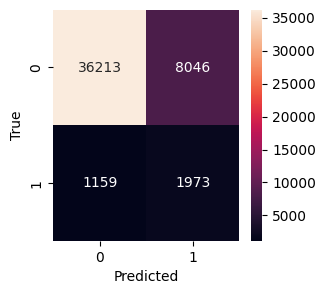

Test - Recall: 0.6299, F1: 0.3001, Accuracy: 0.8058
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.00it/s]


Epoch 4/200, Loss: 0.5573


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.66it/s]


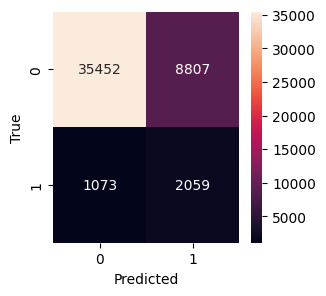

Test - Recall: 0.6574, F1: 0.2942, Accuracy: 0.7915
✅ Saved new best model at Epoch 4 with Score: 0.7183
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.04it/s]


Epoch 5/200, Loss: 0.5460


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.07it/s]


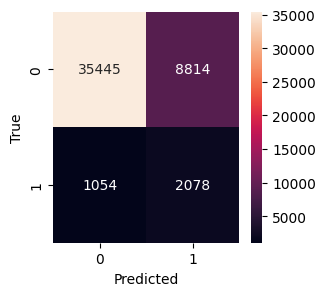

Test - Recall: 0.6635, F1: 0.2963, Accuracy: 0.7918
✅ Saved new best model at Epoch 5 with Score: 0.7220
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.14it/s]


Epoch 6/200, Loss: 0.5364


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.00it/s]


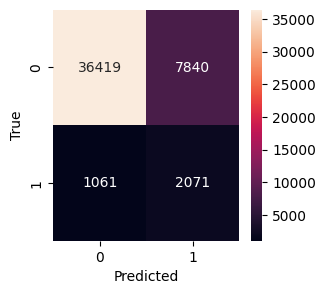

Test - Recall: 0.6612, F1: 0.3176, Accuracy: 0.8122
✅ Saved new best model at Epoch 6 with Score: 0.7290
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.75it/s]


Epoch 7/200, Loss: 0.5259


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.33it/s]


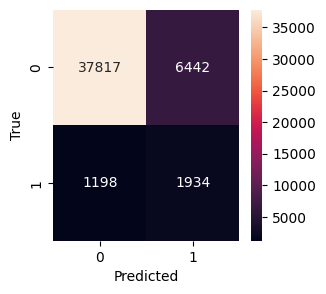

Test - Recall: 0.6175, F1: 0.3361, Accuracy: 0.8388
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.53it/s]


Epoch 8/200, Loss: 0.5276


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.89it/s]


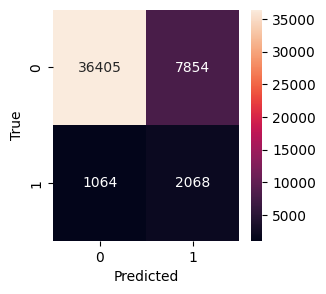

Test - Recall: 0.6603, F1: 0.3168, Accuracy: 0.8118
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.10it/s]


Epoch 9/200, Loss: 0.5147


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.15it/s]


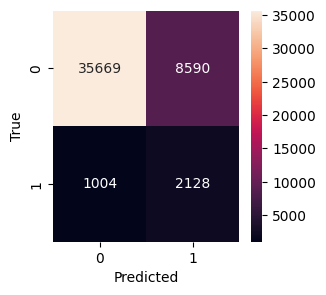

Test - Recall: 0.6794, F1: 0.3073, Accuracy: 0.7976
✅ Saved new best model at Epoch 9 with Score: 0.7338
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.78it/s]


Epoch 10/200, Loss: 0.5114


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.81it/s]


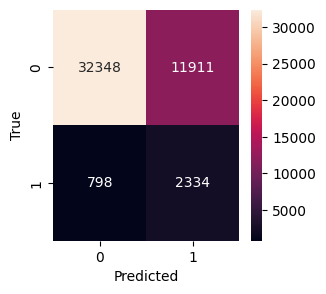

Test - Recall: 0.7452, F1: 0.2686, Accuracy: 0.7318
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.22it/s]


Epoch 11/200, Loss: 0.5075


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.09it/s]


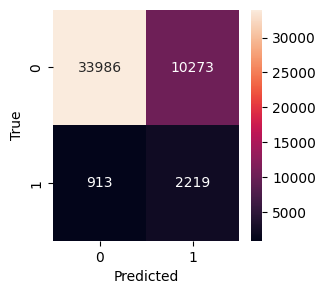

Test - Recall: 0.7085, F1: 0.2841, Accuracy: 0.7640
✅ Saved new best model at Epoch 11 with Score: 0.7352
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.34it/s]


Epoch 12/200, Loss: 0.5039


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.48it/s]


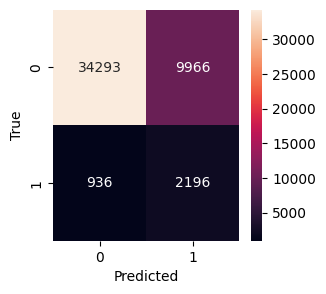

Test - Recall: 0.7011, F1: 0.2872, Accuracy: 0.7700
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.12it/s]


Epoch 13/200, Loss: 0.5058


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.69it/s]


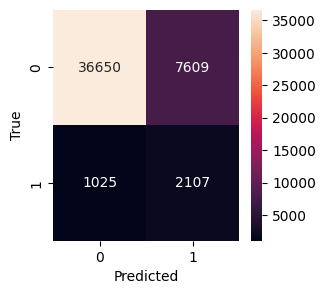

Test - Recall: 0.6727, F1: 0.3280, Accuracy: 0.8178
✅ Saved new best model at Epoch 13 with Score: 0.7382
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.62it/s]


Epoch 14/200, Loss: 0.4967


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.87it/s]


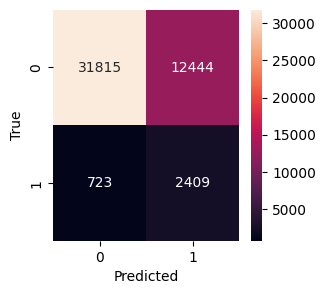

Test - Recall: 0.7692, F1: 0.2679, Accuracy: 0.7222
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.63it/s]


Epoch 15/200, Loss: 0.4918


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.08it/s]


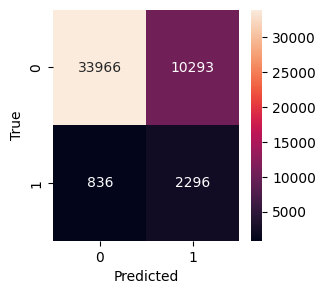

Test - Recall: 0.7331, F1: 0.2921, Accuracy: 0.7652
✅ Saved new best model at Epoch 15 with Score: 0.7488
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.78it/s]


Epoch 16/200, Loss: 0.4917


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.32it/s]


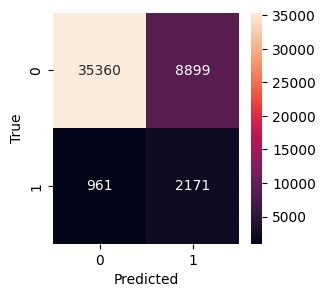

Test - Recall: 0.6932, F1: 0.3057, Accuracy: 0.7919
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.60it/s]


Epoch 17/200, Loss: 0.5007


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.60it/s]


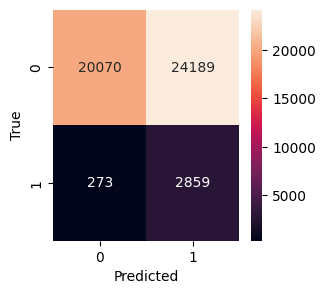

Test - Recall: 0.9128, F1: 0.1895, Accuracy: 0.4838
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.04it/s]


Epoch 18/200, Loss: 0.4970


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.25it/s]


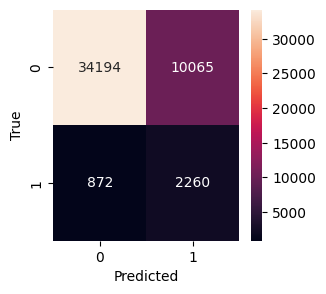

Test - Recall: 0.7216, F1: 0.2924, Accuracy: 0.7692
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.08it/s]


Epoch 19/200, Loss: 0.4870


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.94it/s]


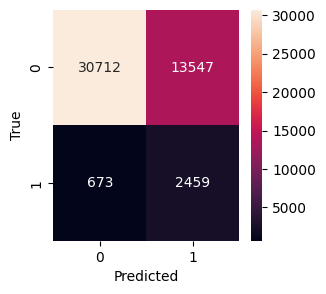

Test - Recall: 0.7851, F1: 0.2570, Accuracy: 0.6999
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.60it/s]


Epoch 20/200, Loss: 0.4844


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 99.55it/s] 


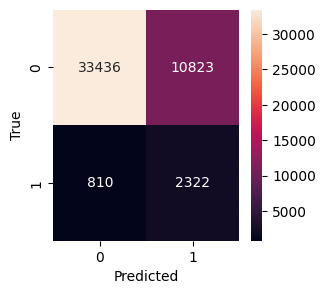

Test - Recall: 0.7414, F1: 0.2853, Accuracy: 0.7545
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.00it/s]


Epoch 21/200, Loss: 0.4780


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.10it/s]


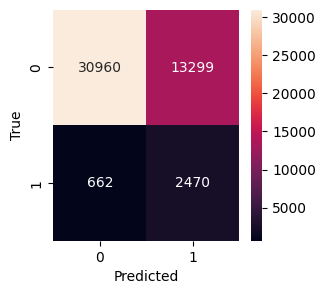

Test - Recall: 0.7886, F1: 0.2614, Accuracy: 0.7054
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.87it/s]


Epoch 22/200, Loss: 0.4751


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.17it/s]


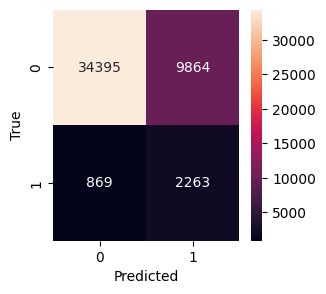

Test - Recall: 0.7225, F1: 0.2966, Accuracy: 0.7735
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.77it/s]


Epoch 23/200, Loss: 0.4741


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.52it/s]


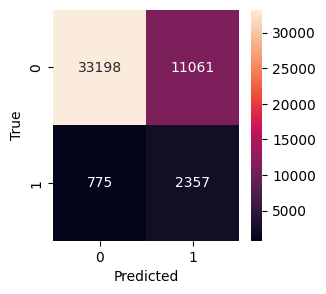

Test - Recall: 0.7526, F1: 0.2848, Accuracy: 0.7502
✅ Saved new best model at Epoch 23 with Score: 0.7514
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.01it/s]


Epoch 24/200, Loss: 0.4720


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.67it/s]


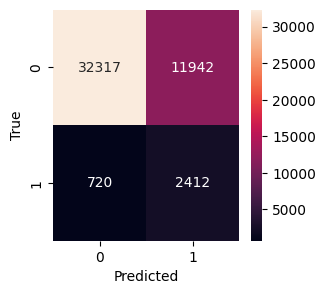

Test - Recall: 0.7701, F1: 0.2759, Accuracy: 0.7328
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.55it/s]


Epoch 25/200, Loss: 0.4747


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.30it/s]


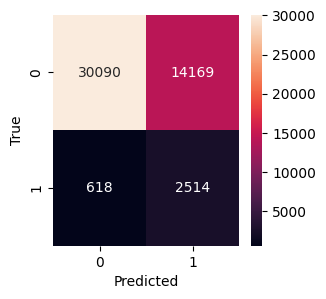

Test - Recall: 0.8027, F1: 0.2537, Accuracy: 0.6880
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.06it/s]


Epoch 26/200, Loss: 0.4710


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.80it/s]


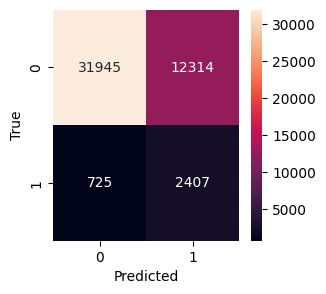

Test - Recall: 0.7685, F1: 0.2696, Accuracy: 0.7249
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.54it/s]


Epoch 27/200, Loss: 0.4697


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.21it/s]


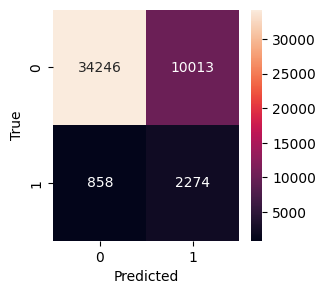

Test - Recall: 0.7261, F1: 0.2950, Accuracy: 0.7706
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.99it/s]


Epoch 28/200, Loss: 0.4681


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.74it/s]


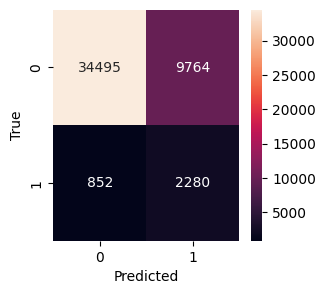

Test - Recall: 0.7280, F1: 0.3005, Accuracy: 0.7760
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.91it/s]


Epoch 29/200, Loss: 0.4619


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.56it/s]


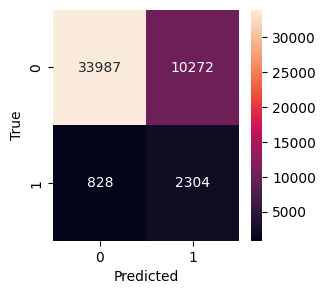

Test - Recall: 0.7356, F1: 0.2934, Accuracy: 0.7658
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.54it/s]


Epoch 30/200, Loss: 0.4593


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.41it/s]


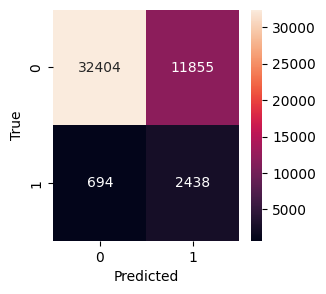

Test - Recall: 0.7784, F1: 0.2798, Accuracy: 0.7352
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.52it/s]


Epoch 31/200, Loss: 0.4579


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.41it/s]


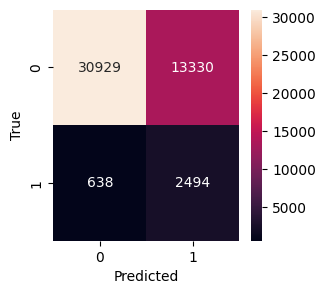

Test - Recall: 0.7963, F1: 0.2631, Accuracy: 0.7053
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.41it/s]


Epoch 32/200, Loss: 0.4595


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.15it/s]


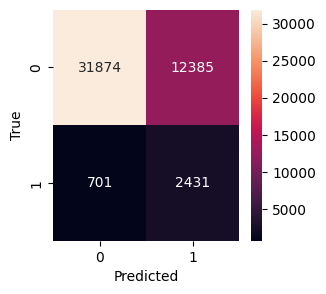

Test - Recall: 0.7762, F1: 0.2709, Accuracy: 0.7239
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.53it/s]


Epoch 33/200, Loss: 0.4564


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.32it/s]


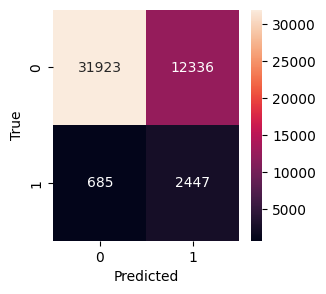

Test - Recall: 0.7813, F1: 0.2732, Accuracy: 0.7252
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.17it/s]


Epoch 34/200, Loss: 0.4538


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.92it/s]


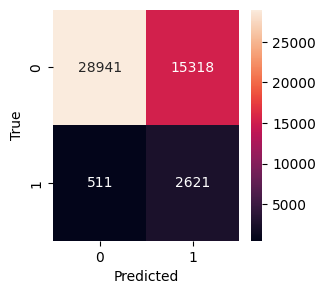

Test - Recall: 0.8368, F1: 0.2488, Accuracy: 0.6660
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.22it/s]


Epoch 35/200, Loss: 0.4481


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.70it/s]


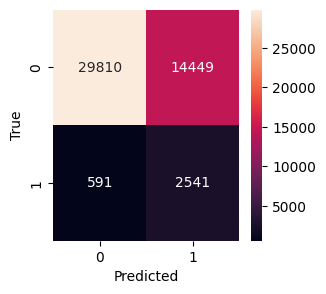

Test - Recall: 0.8113, F1: 0.2526, Accuracy: 0.6826
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.36it/s]


Epoch 36/200, Loss: 0.4495


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.22it/s]


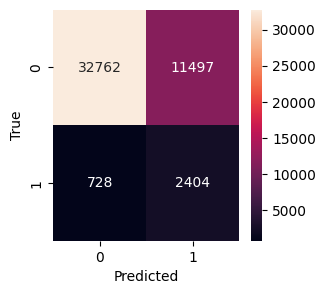

Test - Recall: 0.7676, F1: 0.2823, Accuracy: 0.7420
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.82it/s]


Epoch 37/200, Loss: 0.4490


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.12it/s]


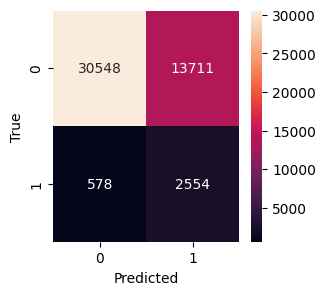

Test - Recall: 0.8155, F1: 0.2633, Accuracy: 0.6985
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.26it/s]


Epoch 38/200, Loss: 0.4463


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.24it/s]


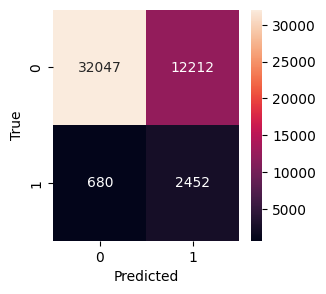

Test - Recall: 0.7829, F1: 0.2756, Accuracy: 0.7280
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.49it/s]


Epoch 39/200, Loss: 0.4510


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 97.36it/s] 


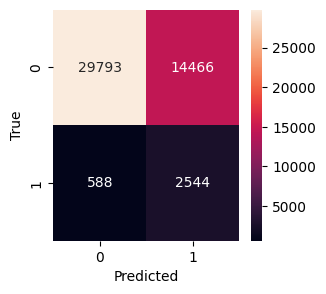

Test - Recall: 0.8123, F1: 0.2526, Accuracy: 0.6823
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.35it/s]


Epoch 40/200, Loss: 0.4463


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.78it/s]


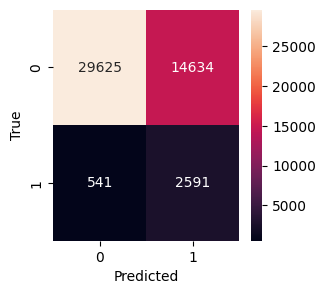

Test - Recall: 0.8273, F1: 0.2546, Accuracy: 0.6798
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.56it/s]


Epoch 41/200, Loss: 0.4422


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.52it/s]


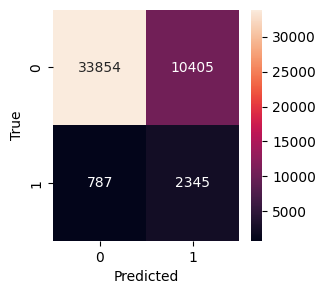

Test - Recall: 0.7487, F1: 0.2953, Accuracy: 0.7638
✅ Saved new best model at Epoch 41 with Score: 0.7562
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.16it/s]


Epoch 42/200, Loss: 0.4390


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.94it/s]


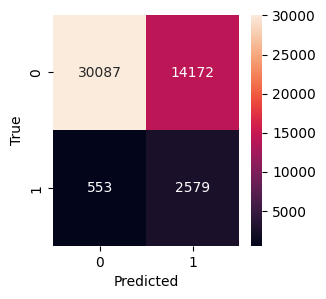

Test - Recall: 0.8234, F1: 0.2594, Accuracy: 0.6893
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.65it/s]


Epoch 43/200, Loss: 0.4335


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.91it/s]


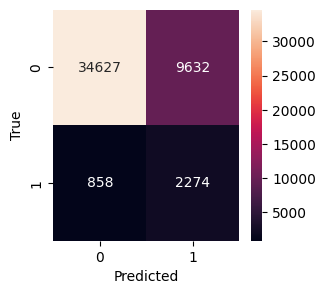

Test - Recall: 0.7261, F1: 0.3024, Accuracy: 0.7786
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.86it/s]


Epoch 44/200, Loss: 0.4422


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.20it/s]


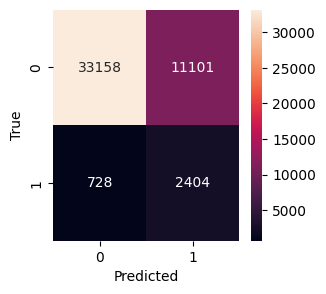

Test - Recall: 0.7676, F1: 0.2890, Accuracy: 0.7504
✅ Saved new best model at Epoch 44 with Score: 0.7589
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.53it/s]


Epoch 45/200, Loss: 0.4360


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.85it/s]


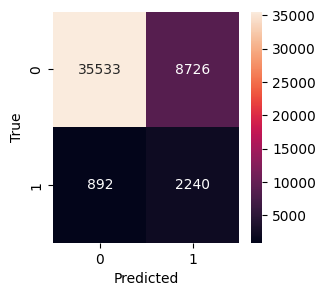

Test - Recall: 0.7152, F1: 0.3178, Accuracy: 0.7971
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.04it/s]


Epoch 46/200, Loss: 0.4336


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.17it/s]


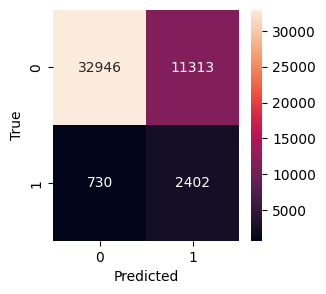

Test - Recall: 0.7669, F1: 0.2852, Accuracy: 0.7459
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.48it/s]


Epoch 47/200, Loss: 0.4297


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.82it/s]


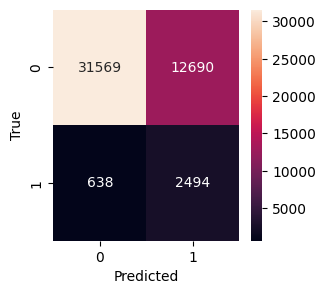

Test - Recall: 0.7963, F1: 0.2723, Accuracy: 0.7188
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.31it/s]


Epoch 48/200, Loss: 0.4292


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.38it/s]


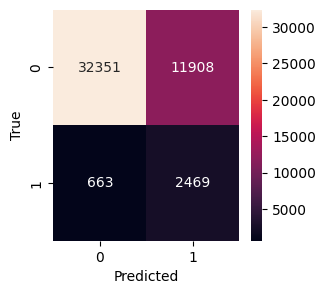

Test - Recall: 0.7883, F1: 0.2820, Accuracy: 0.7347
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.67it/s]


Epoch 49/200, Loss: 0.4265


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.63it/s]


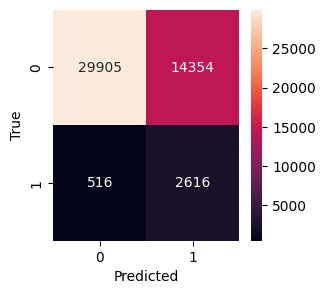

Test - Recall: 0.8352, F1: 0.2603, Accuracy: 0.6862
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.27it/s]


Epoch 50/200, Loss: 0.4246


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.84it/s]


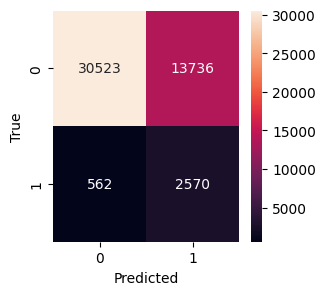

Test - Recall: 0.8206, F1: 0.2644, Accuracy: 0.6983
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.25it/s]


Epoch 51/200, Loss: 0.4314


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.71it/s]


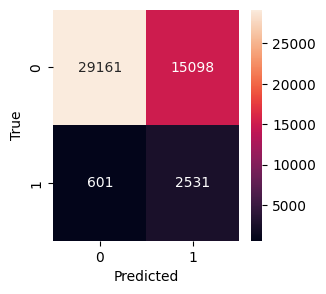

Test - Recall: 0.8081, F1: 0.2438, Accuracy: 0.6687
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.15it/s]


Epoch 52/200, Loss: 0.4451


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.01it/s]


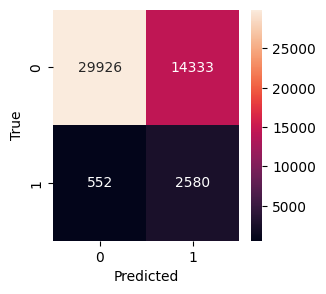

Test - Recall: 0.8238, F1: 0.2574, Accuracy: 0.6859
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.52it/s]


Epoch 53/200, Loss: 0.4319


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.70it/s]


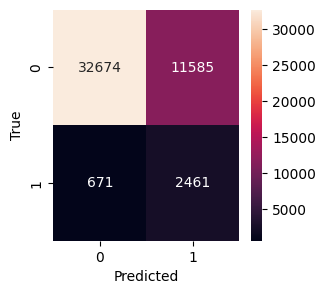

Test - Recall: 0.7858, F1: 0.2865, Accuracy: 0.7414
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.67it/s]


Epoch 54/200, Loss: 0.4232


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.40it/s]


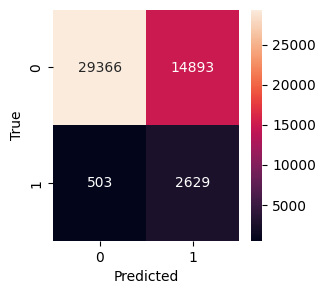

Test - Recall: 0.8394, F1: 0.2546, Accuracy: 0.6751
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.02it/s]


Epoch 55/200, Loss: 0.4203


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.73it/s]


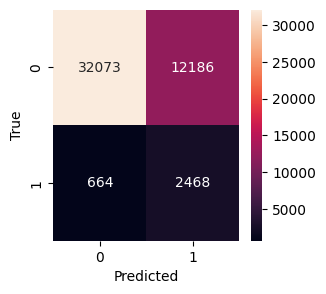

Test - Recall: 0.7880, F1: 0.2775, Accuracy: 0.7289
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.08it/s]


Epoch 56/200, Loss: 0.4170


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.60it/s]


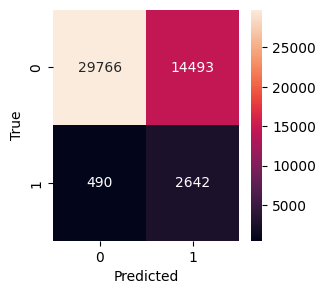

Test - Recall: 0.8436, F1: 0.2607, Accuracy: 0.6838
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.20it/s]


Epoch 57/200, Loss: 0.4183


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.67it/s]


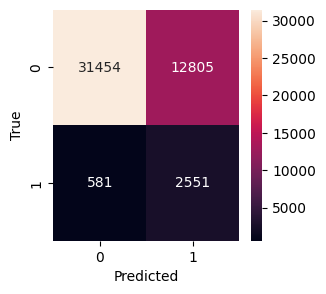

Test - Recall: 0.8145, F1: 0.2760, Accuracy: 0.7175
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.49it/s]


Epoch 58/200, Loss: 0.4144


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.24it/s]


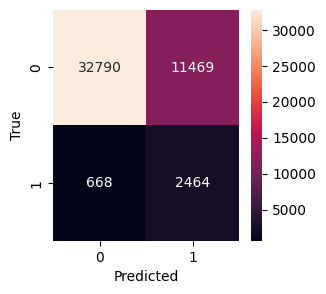

Test - Recall: 0.7867, F1: 0.2888, Accuracy: 0.7439
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.30it/s]


Epoch 59/200, Loss: 0.4147


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.91it/s]


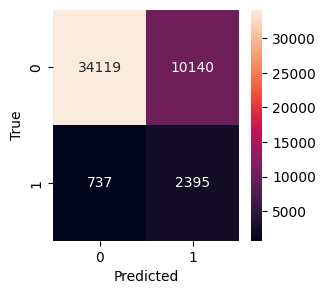

Test - Recall: 0.7647, F1: 0.3057, Accuracy: 0.7705
✅ Saved new best model at Epoch 59 with Score: 0.7676
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.30it/s]


Epoch 60/200, Loss: 0.4161


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.01it/s]


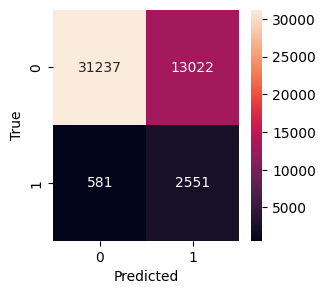

Test - Recall: 0.8145, F1: 0.2728, Accuracy: 0.7130
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.31it/s]


Epoch 61/200, Loss: 0.4122


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.11it/s]


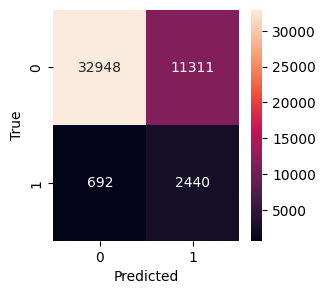

Test - Recall: 0.7791, F1: 0.2890, Accuracy: 0.7467
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.48it/s]


Epoch 62/200, Loss: 0.4094


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.22it/s]


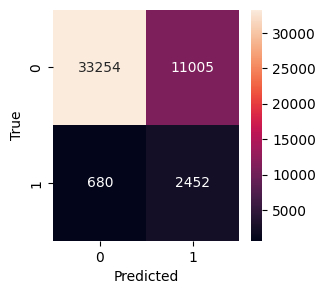

Test - Recall: 0.7829, F1: 0.2956, Accuracy: 0.7534
✅ Saved new best model at Epoch 62 with Score: 0.7679
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.34it/s]


Epoch 63/200, Loss: 0.4093


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.14it/s]


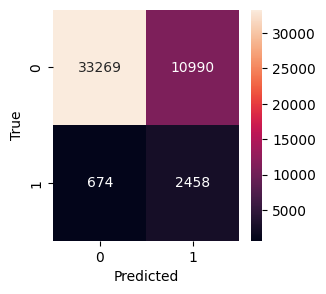

Test - Recall: 0.7848, F1: 0.2965, Accuracy: 0.7539
✅ Saved new best model at Epoch 63 with Score: 0.7690
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.07it/s]


Epoch 64/200, Loss: 0.4066


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.22it/s]


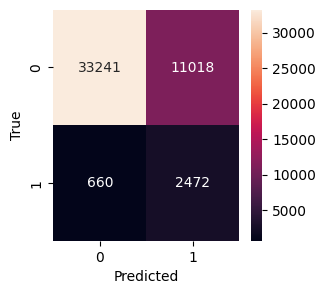

Test - Recall: 0.7893, F1: 0.2974, Accuracy: 0.7536
✅ Saved new best model at Epoch 64 with Score: 0.7710
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.73it/s]


Epoch 65/200, Loss: 0.4107


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.07it/s]


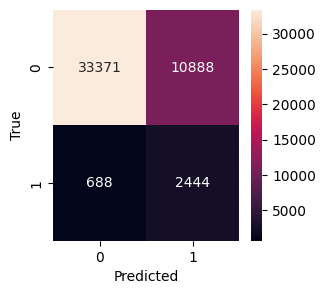

Test - Recall: 0.7803, F1: 0.2969, Accuracy: 0.7557
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.27it/s]


Epoch 66/200, Loss: 0.4022


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.12it/s]


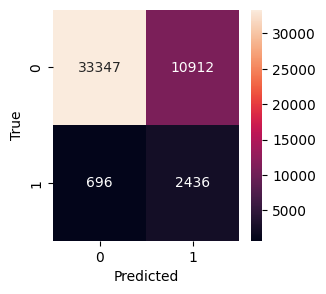

Test - Recall: 0.7778, F1: 0.2956, Accuracy: 0.7551
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.10it/s]


Epoch 67/200, Loss: 0.4041


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.86it/s]


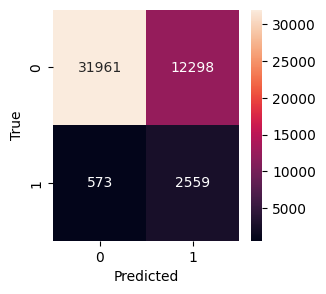

Test - Recall: 0.8170, F1: 0.2845, Accuracy: 0.7284
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.50it/s]


Epoch 68/200, Loss: 0.4014


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.56it/s]


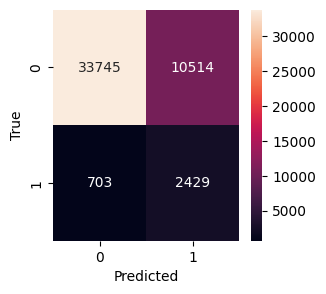

Test - Recall: 0.7755, F1: 0.3022, Accuracy: 0.7633
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.53it/s]


Epoch 69/200, Loss: 0.4008


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.09it/s]


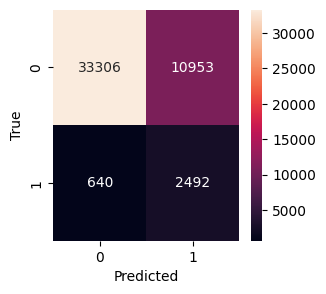

Test - Recall: 0.7957, F1: 0.3007, Accuracy: 0.7554
✅ Saved new best model at Epoch 69 with Score: 0.7750
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.49it/s]


Epoch 70/200, Loss: 0.3981


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.43it/s]


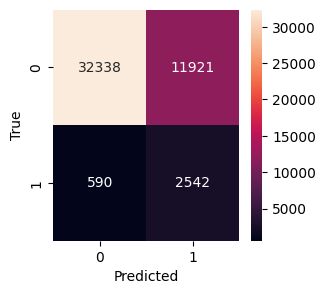

Test - Recall: 0.8116, F1: 0.2889, Accuracy: 0.7360
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.74it/s]


Epoch 71/200, Loss: 0.4023


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.34it/s]


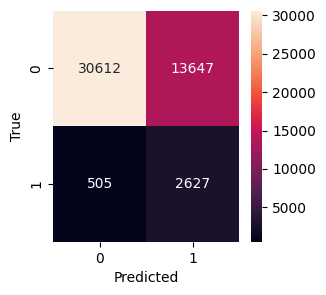

Test - Recall: 0.8388, F1: 0.2707, Accuracy: 0.7014
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.26it/s]


Epoch 72/200, Loss: 0.4000


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.28it/s]


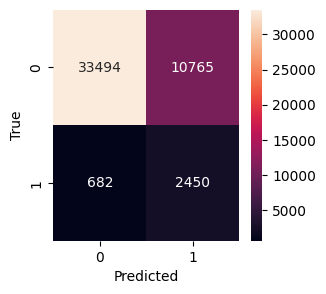

Test - Recall: 0.7822, F1: 0.2997, Accuracy: 0.7585
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.45it/s]


Epoch 73/200, Loss: 0.3990


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.66it/s]


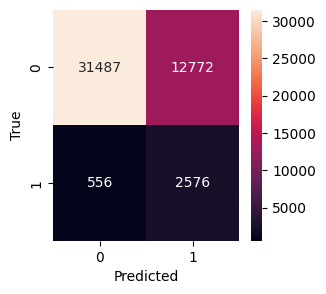

Test - Recall: 0.8225, F1: 0.2788, Accuracy: 0.7188
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.93it/s]


Epoch 74/200, Loss: 0.3956


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.40it/s]


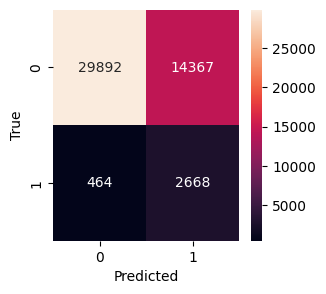

Test - Recall: 0.8519, F1: 0.2646, Accuracy: 0.6871
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.70it/s]


Epoch 75/200, Loss: 0.3987


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.43it/s]


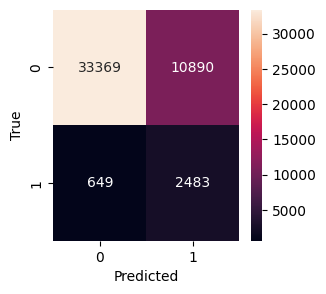

Test - Recall: 0.7928, F1: 0.3009, Accuracy: 0.7565
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.83it/s]


Epoch 76/200, Loss: 0.3965


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.53it/s]


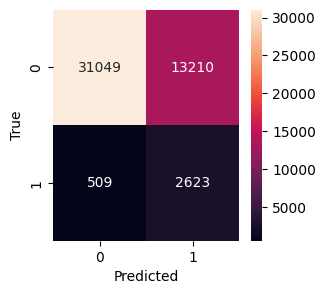

Test - Recall: 0.8375, F1: 0.2766, Accuracy: 0.7105
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.54it/s]


Epoch 77/200, Loss: 0.3947


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.88it/s]


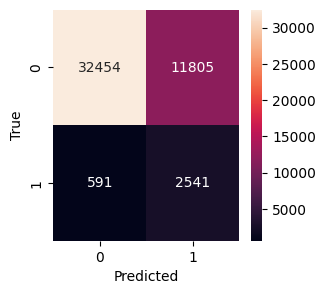

Test - Recall: 0.8113, F1: 0.2908, Accuracy: 0.7384
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 28.92it/s]


Epoch 78/200, Loss: 0.3932


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.51it/s]


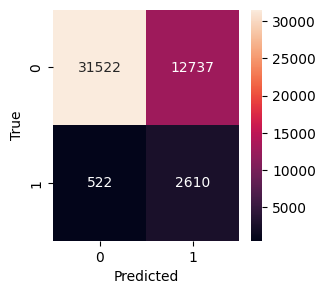

Test - Recall: 0.8333, F1: 0.2825, Accuracy: 0.7202
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.52it/s]


Epoch 79/200, Loss: 0.3918


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 101.83it/s]


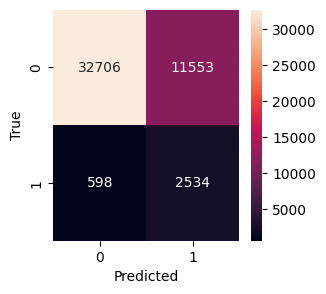

Test - Recall: 0.8091, F1: 0.2943, Accuracy: 0.7436
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.50it/s]


Epoch 80/200, Loss: 0.3946


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.93it/s]


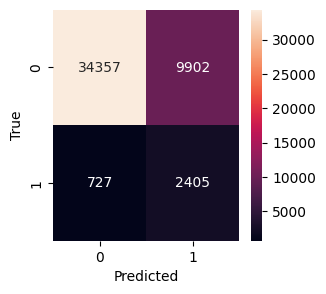

Test - Recall: 0.7679, F1: 0.3115, Accuracy: 0.7757
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.36it/s]


Epoch 81/200, Loss: 0.3903


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.34it/s]


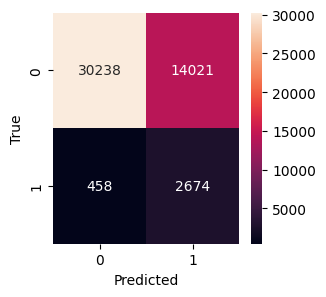

Test - Recall: 0.8538, F1: 0.2697, Accuracy: 0.6945
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.77it/s]


Epoch 82/200, Loss: 0.3859


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.22it/s]


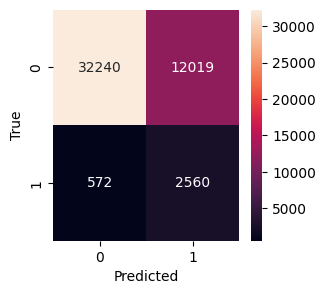

Test - Recall: 0.8174, F1: 0.2891, Accuracy: 0.7343
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.96it/s]


Epoch 83/200, Loss: 0.3893


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.49it/s]


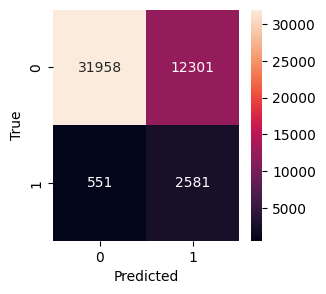

Test - Recall: 0.8241, F1: 0.2866, Accuracy: 0.7288
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.17it/s]


Epoch 84/200, Loss: 0.3875


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.46it/s]


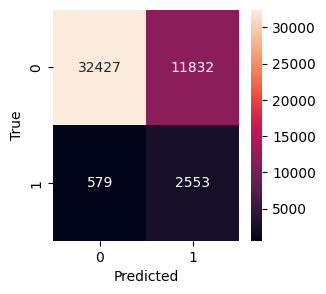

Test - Recall: 0.8151, F1: 0.2915, Accuracy: 0.7381
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.57it/s]


Epoch 85/200, Loss: 0.3877


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.26it/s]


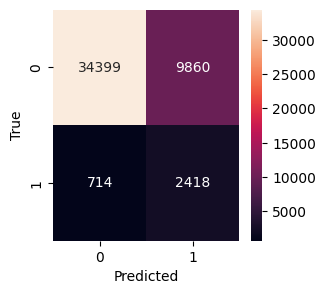

Test - Recall: 0.7720, F1: 0.3138, Accuracy: 0.7769
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.90it/s]


Epoch 86/200, Loss: 0.3873


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.98it/s]


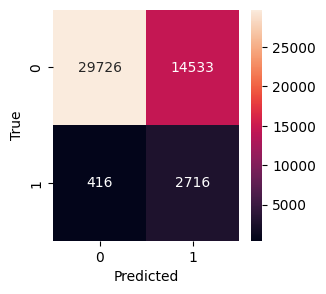

Test - Recall: 0.8672, F1: 0.2665, Accuracy: 0.6846
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.39it/s]


Epoch 87/200, Loss: 0.3850


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.02it/s]


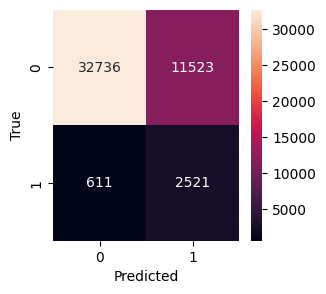

Test - Recall: 0.8049, F1: 0.2935, Accuracy: 0.7440
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.88it/s]


Epoch 88/200, Loss: 0.3838


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.43it/s]


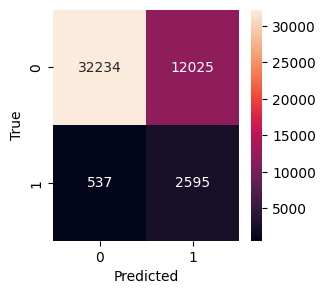

Test - Recall: 0.8285, F1: 0.2924, Accuracy: 0.7349
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.32it/s]


Epoch 89/200, Loss: 0.3854


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.33it/s]


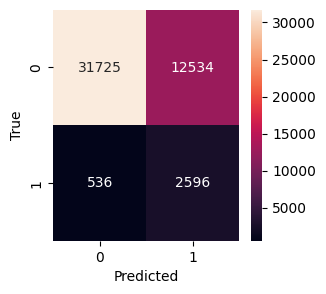

Test - Recall: 0.8289, F1: 0.2843, Accuracy: 0.7242
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.47it/s]


Epoch 90/200, Loss: 0.3837


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.43it/s]


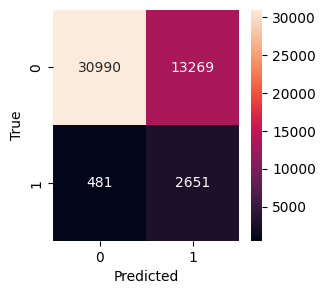

Test - Recall: 0.8464, F1: 0.2783, Accuracy: 0.7099
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.11it/s]


Epoch 91/200, Loss: 0.3874


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.62it/s]


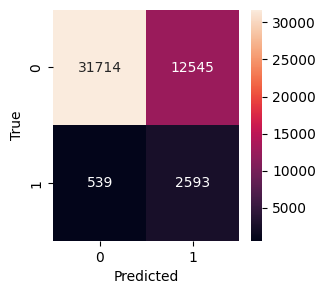

Test - Recall: 0.8279, F1: 0.2839, Accuracy: 0.7239
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.90it/s]


Epoch 92/200, Loss: 0.3888


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.06it/s]


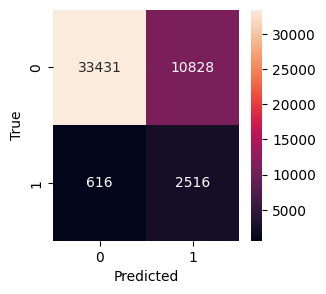

Test - Recall: 0.8033, F1: 0.3054, Accuracy: 0.7585
✅ Saved new best model at Epoch 92 with Score: 0.7803
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.41it/s]


Epoch 93/200, Loss: 0.3831


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.03it/s]


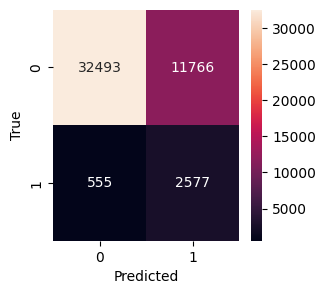

Test - Recall: 0.8228, F1: 0.2949, Accuracy: 0.7400
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.94it/s]


Epoch 94/200, Loss: 0.3828


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.94it/s]


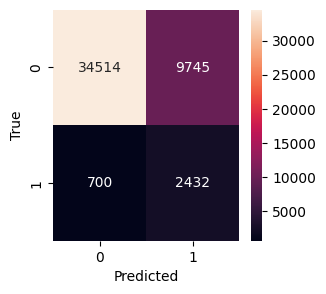

Test - Recall: 0.7765, F1: 0.3177, Accuracy: 0.7796
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.59it/s]


Epoch 95/200, Loss: 0.3836


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.27it/s]


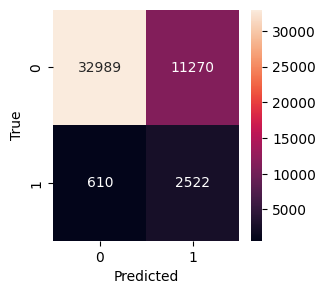

Test - Recall: 0.8052, F1: 0.2980, Accuracy: 0.7493
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.06it/s]


Epoch 96/200, Loss: 0.3796


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.68it/s]


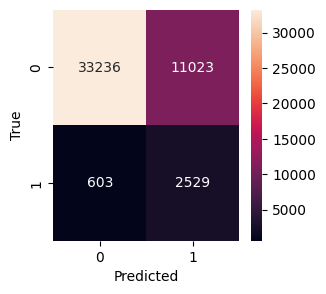

Test - Recall: 0.8075, F1: 0.3032, Accuracy: 0.7547
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.46it/s]


Epoch 97/200, Loss: 0.3816


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 100.36it/s]


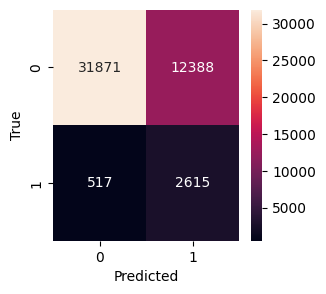

Test - Recall: 0.8349, F1: 0.2884, Accuracy: 0.7277
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.79it/s]


Epoch 98/200, Loss: 0.3806


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.55it/s]


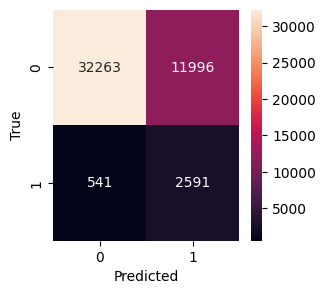

Test - Recall: 0.8273, F1: 0.2925, Accuracy: 0.7355
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.46it/s]


Epoch 99/200, Loss: 0.3769


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.13it/s]


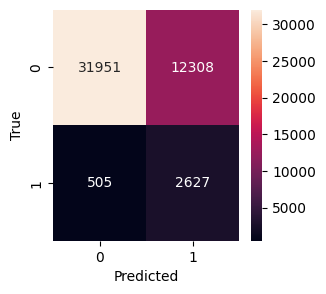

Test - Recall: 0.8388, F1: 0.2908, Accuracy: 0.7296
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.37it/s]


Epoch 100/200, Loss: 0.3777


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.17it/s]


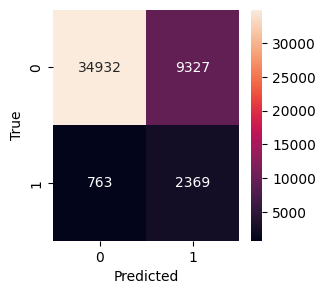

Test - Recall: 0.7564, F1: 0.3195, Accuracy: 0.7871
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.20it/s]


Epoch 101/200, Loss: 0.3780


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.39it/s]


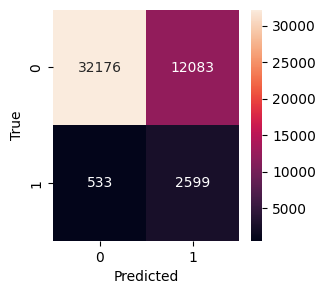

Test - Recall: 0.8298, F1: 0.2918, Accuracy: 0.7338
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.05it/s]


Epoch 102/200, Loss: 0.3782


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.10it/s]


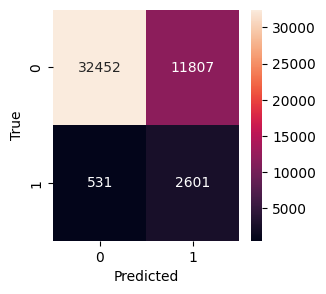

Test - Recall: 0.8305, F1: 0.2966, Accuracy: 0.7397
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.97it/s]


Epoch 103/200, Loss: 0.3772


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.43it/s]


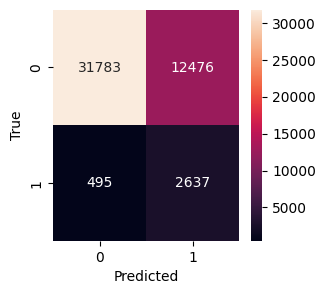

Test - Recall: 0.8420, F1: 0.2891, Accuracy: 0.7263
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.72it/s]


Epoch 104/200, Loss: 0.3760


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.61it/s]


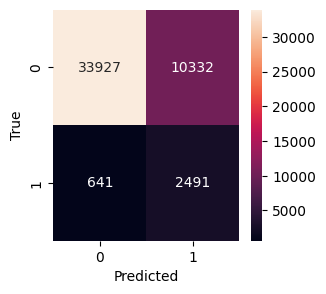

Test - Recall: 0.7953, F1: 0.3123, Accuracy: 0.7685
✅ Saved new best model at Epoch 104 with Score: 0.7817
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.73it/s]


Epoch 105/200, Loss: 0.3752


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.07it/s]


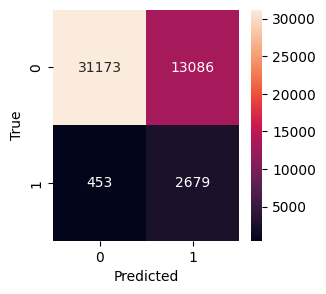

Test - Recall: 0.8554, F1: 0.2835, Accuracy: 0.7143
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.58it/s]


Epoch 106/200, Loss: 0.3765


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.81it/s]


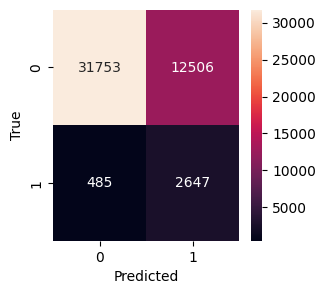

Test - Recall: 0.8451, F1: 0.2895, Accuracy: 0.7259
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.75it/s]


Epoch 107/200, Loss: 0.3711


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.77it/s]


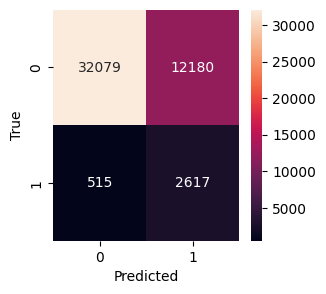

Test - Recall: 0.8356, F1: 0.2919, Accuracy: 0.7321
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.69it/s]


Epoch 108/200, Loss: 0.3717


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.82it/s]


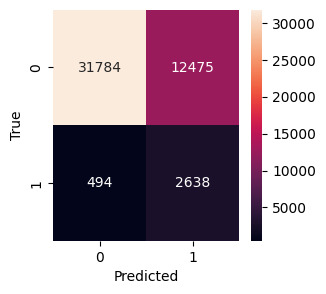

Test - Recall: 0.8423, F1: 0.2892, Accuracy: 0.7263
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.68it/s]


Epoch 109/200, Loss: 0.3728


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.51it/s]


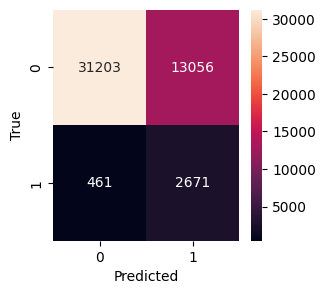

Test - Recall: 0.8528, F1: 0.2833, Accuracy: 0.7148
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.19it/s]


Epoch 110/200, Loss: 0.3738


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.45it/s]


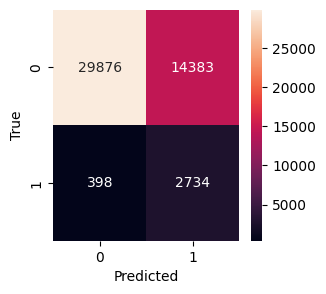

Test - Recall: 0.8729, F1: 0.2700, Accuracy: 0.6881
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.33it/s]


Epoch 111/200, Loss: 0.3732


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.42it/s]


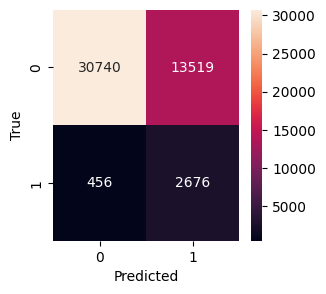

Test - Recall: 0.8544, F1: 0.2769, Accuracy: 0.7051
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.19it/s]


Epoch 112/200, Loss: 0.3704


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.41it/s]


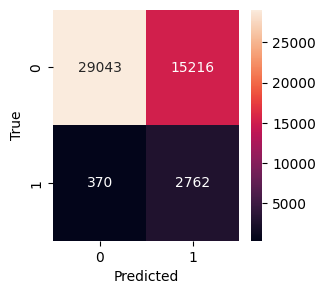

Test - Recall: 0.8819, F1: 0.2617, Accuracy: 0.6711
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.06it/s]


Epoch 113/200, Loss: 0.3677


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.16it/s]


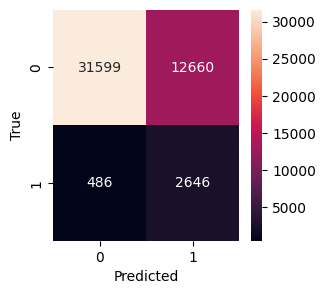

Test - Recall: 0.8448, F1: 0.2870, Accuracy: 0.7226
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.75it/s]


Epoch 114/200, Loss: 0.3698


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.35it/s]


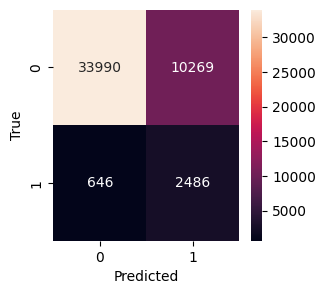

Test - Recall: 0.7937, F1: 0.3130, Accuracy: 0.7697
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.46it/s]


Epoch 115/200, Loss: 0.3686


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.20it/s]


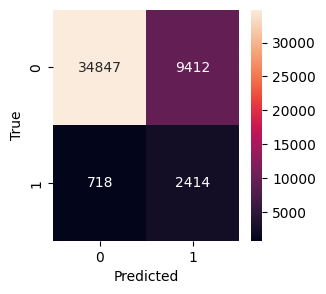

Test - Recall: 0.7708, F1: 0.3228, Accuracy: 0.7862
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.98it/s]


Epoch 116/200, Loss: 0.3674


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 100.22it/s]


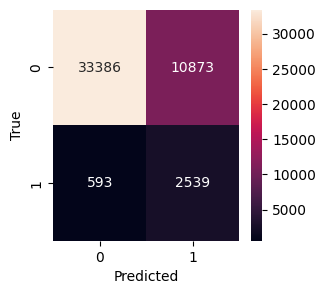

Test - Recall: 0.8107, F1: 0.3069, Accuracy: 0.7581
✅ Saved new best model at Epoch 116 with Score: 0.7835
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.90it/s]


Epoch 117/200, Loss: 0.3666


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.57it/s]


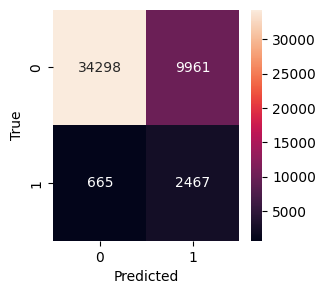

Test - Recall: 0.7877, F1: 0.3171, Accuracy: 0.7758
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.23it/s]


Epoch 118/200, Loss: 0.3686


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.86it/s]


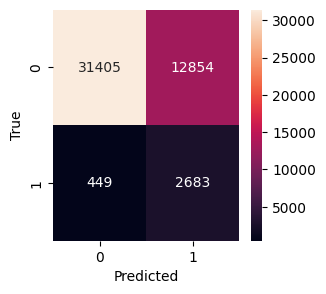

Test - Recall: 0.8566, F1: 0.2874, Accuracy: 0.7193
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.42it/s]


Epoch 119/200, Loss: 0.3684


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.77it/s]


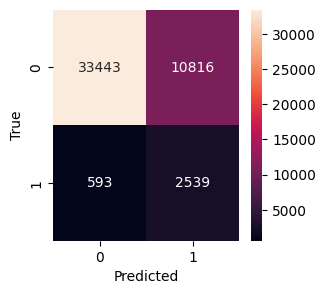

Test - Recall: 0.8107, F1: 0.3080, Accuracy: 0.7593
✅ Saved new best model at Epoch 119 with Score: 0.7841
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.00it/s]


Epoch 120/200, Loss: 0.3683


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.47it/s]


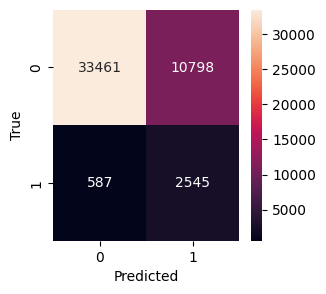

Test - Recall: 0.8126, F1: 0.3090, Accuracy: 0.7598
✅ Saved new best model at Epoch 120 with Score: 0.7853
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.90it/s]


Epoch 121/200, Loss: 0.3666


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.02it/s]


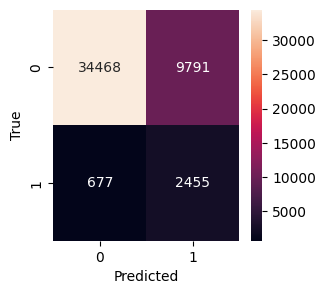

Test - Recall: 0.7838, F1: 0.3193, Accuracy: 0.7791
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.61it/s]


Epoch 122/200, Loss: 0.3686


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 101.54it/s]


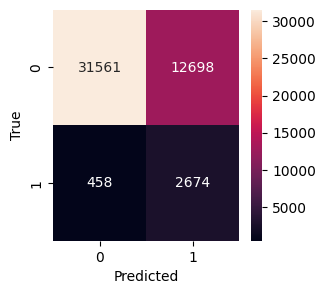

Test - Recall: 0.8538, F1: 0.2890, Accuracy: 0.7224
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.52it/s]


Epoch 123/200, Loss: 0.3654


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.71it/s]


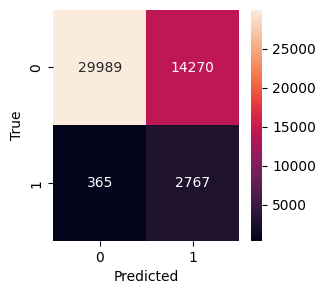

Test - Recall: 0.8835, F1: 0.2744, Accuracy: 0.6912
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.76it/s]


Epoch 124/200, Loss: 0.3652


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 93.55it/s]


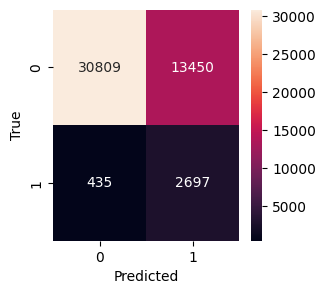

Test - Recall: 0.8611, F1: 0.2798, Accuracy: 0.7070
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.38it/s]


Epoch 125/200, Loss: 0.3645


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.05it/s]


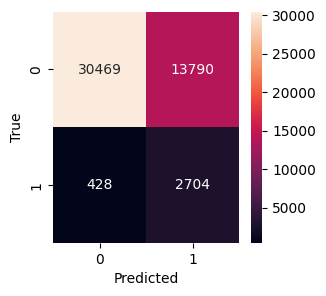

Test - Recall: 0.8633, F1: 0.2756, Accuracy: 0.7000
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.91it/s]


Epoch 126/200, Loss: 0.3644


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.26it/s]


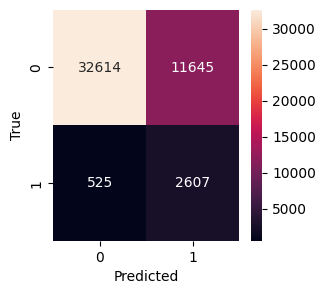

Test - Recall: 0.8324, F1: 0.2999, Accuracy: 0.7432
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 28.80it/s]


Epoch 127/200, Loss: 0.3647


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 100.46it/s]


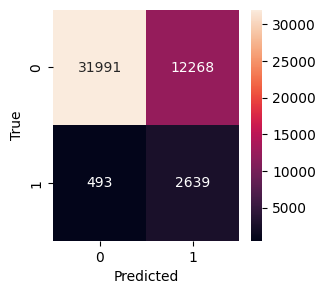

Test - Recall: 0.8426, F1: 0.2926, Accuracy: 0.7307
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.74it/s]


Epoch 128/200, Loss: 0.3631


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.39it/s]


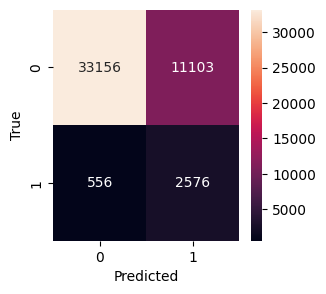

Test - Recall: 0.8225, F1: 0.3065, Accuracy: 0.7540
✅ Saved new best model at Epoch 128 with Score: 0.7867
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.26it/s]


Epoch 129/200, Loss: 0.3586


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.87it/s]


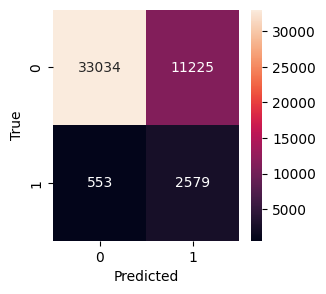

Test - Recall: 0.8234, F1: 0.3046, Accuracy: 0.7515
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.51it/s]


Epoch 130/200, Loss: 0.3629


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.53it/s]


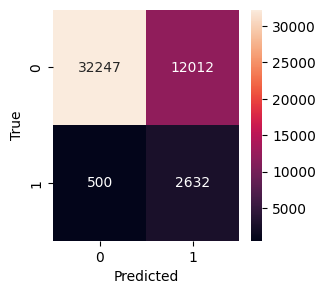

Test - Recall: 0.8404, F1: 0.2961, Accuracy: 0.7360
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.17it/s]


Epoch 131/200, Loss: 0.3637


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.71it/s]


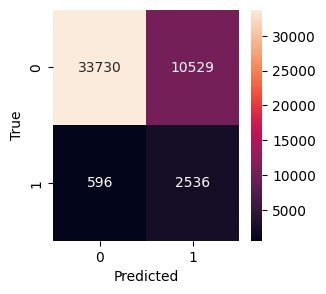

Test - Recall: 0.8097, F1: 0.3131, Accuracy: 0.7653
✅ Saved new best model at Epoch 131 with Score: 0.7869
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.53it/s]


Epoch 132/200, Loss: 0.3620


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.40it/s]


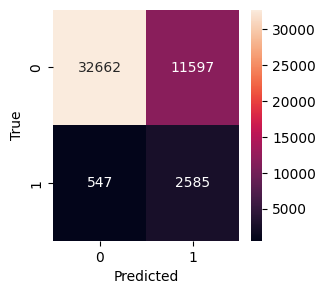

Test - Recall: 0.8254, F1: 0.2986, Accuracy: 0.7437
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.01it/s]


Epoch 133/200, Loss: 0.3613


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.89it/s]


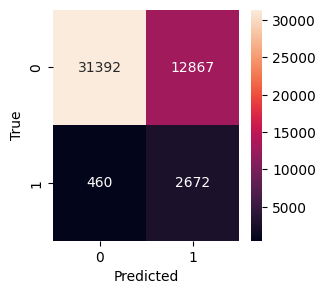

Test - Recall: 0.8531, F1: 0.2862, Accuracy: 0.7188
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.39it/s]


Epoch 134/200, Loss: 0.3646


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.15it/s]


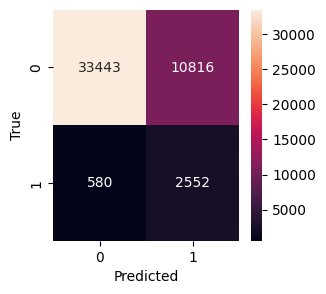

Test - Recall: 0.8148, F1: 0.3093, Accuracy: 0.7595
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.21it/s]


Epoch 135/200, Loss: 0.3616


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.60it/s]


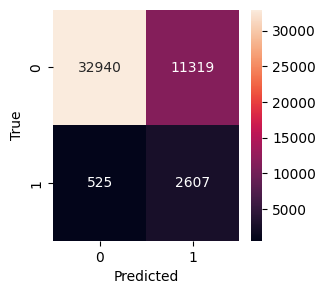

Test - Recall: 0.8324, F1: 0.3057, Accuracy: 0.7501
✅ Saved new best model at Epoch 135 with Score: 0.7891
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.88it/s]


Epoch 136/200, Loss: 0.3616


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.65it/s]


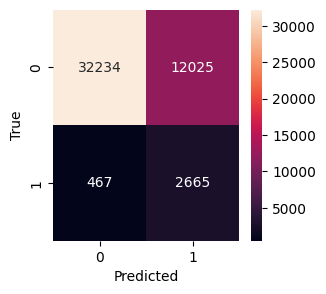

Test - Recall: 0.8509, F1: 0.2991, Accuracy: 0.7364
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.37it/s]


Epoch 137/200, Loss: 0.3564


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.52it/s]


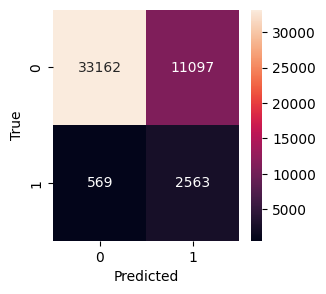

Test - Recall: 0.8183, F1: 0.3053, Accuracy: 0.7538
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.56it/s]


Epoch 138/200, Loss: 0.3577


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.27it/s]


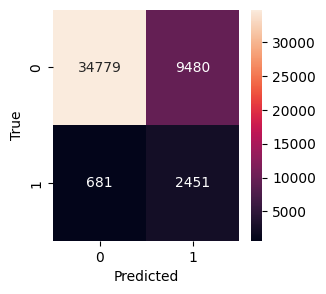

Test - Recall: 0.7826, F1: 0.3254, Accuracy: 0.7856
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.09it/s]


Epoch 139/200, Loss: 0.3600


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.25it/s]


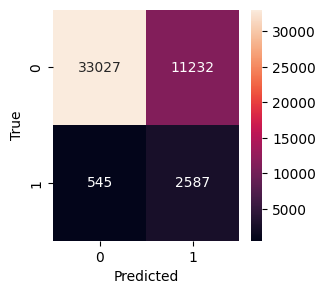

Test - Recall: 0.8260, F1: 0.3052, Accuracy: 0.7515
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.33it/s]


Epoch 140/200, Loss: 0.3594


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.04it/s]


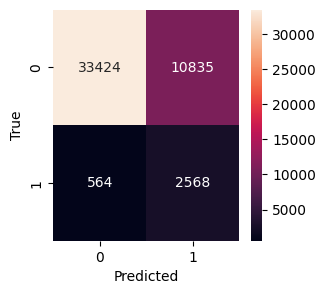

Test - Recall: 0.8199, F1: 0.3106, Accuracy: 0.7595
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.35it/s]


Epoch 141/200, Loss: 0.3550


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.32it/s]


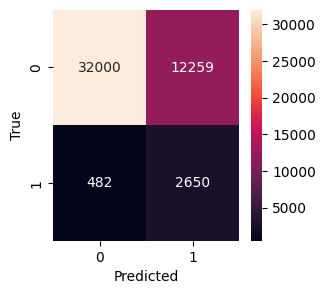

Test - Recall: 0.8461, F1: 0.2938, Accuracy: 0.7312
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.46it/s]


Epoch 142/200, Loss: 0.3563


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.16it/s]


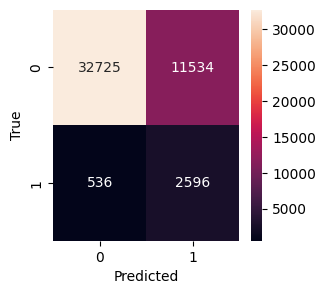

Test - Recall: 0.8289, F1: 0.3008, Accuracy: 0.7453
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.87it/s]


Epoch 143/200, Loss: 0.3541


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.33it/s]


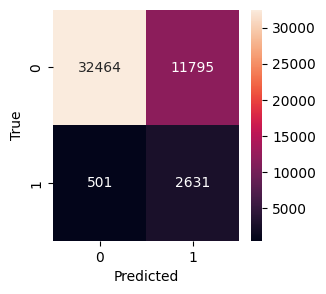

Test - Recall: 0.8400, F1: 0.2997, Accuracy: 0.7405
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.46it/s]


Epoch 144/200, Loss: 0.3520


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.98it/s]


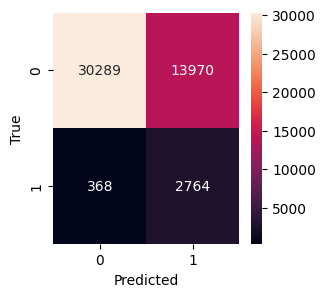

Test - Recall: 0.8825, F1: 0.2783, Accuracy: 0.6975
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.98it/s]


Epoch 145/200, Loss: 0.3561


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.17it/s]


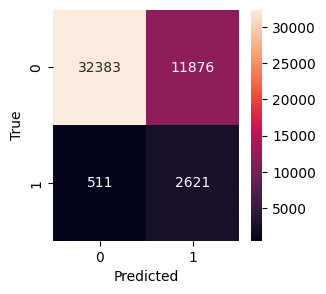

Test - Recall: 0.8368, F1: 0.2974, Accuracy: 0.7386
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.08it/s]


Epoch 146/200, Loss: 0.3576


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.62it/s]


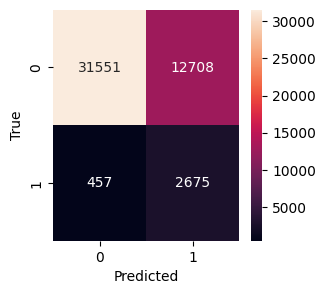

Test - Recall: 0.8541, F1: 0.2890, Accuracy: 0.7222
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.11it/s]


Epoch 147/200, Loss: 0.3521


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.45it/s]


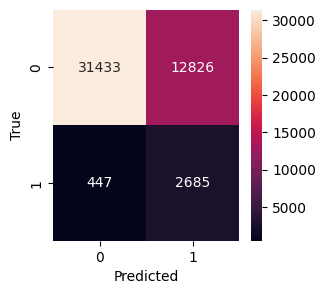

Test - Recall: 0.8573, F1: 0.2880, Accuracy: 0.7199
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.86it/s]


Epoch 148/200, Loss: 0.3550


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.02it/s]


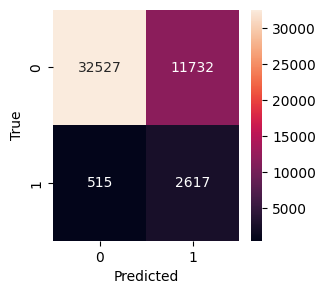

Test - Recall: 0.8356, F1: 0.2994, Accuracy: 0.7416
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.64it/s]


Epoch 149/200, Loss: 0.3514


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.98it/s]


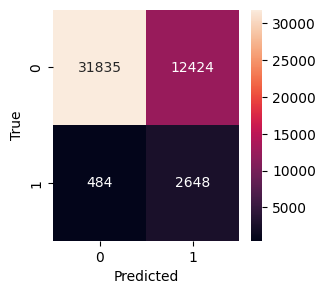

Test - Recall: 0.8455, F1: 0.2909, Accuracy: 0.7276
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.51it/s]


Epoch 150/200, Loss: 0.3571


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.65it/s]


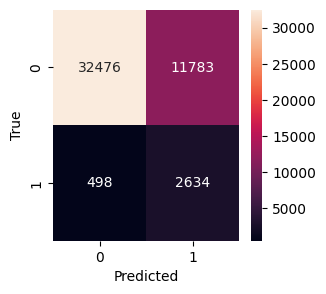

Test - Recall: 0.8410, F1: 0.3002, Accuracy: 0.7409
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.12it/s]


Epoch 151/200, Loss: 0.3564


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.54it/s]


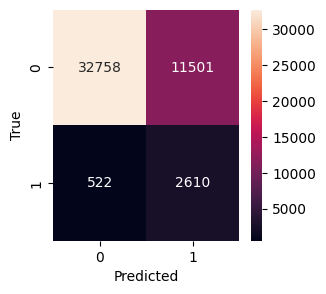

Test - Recall: 0.8333, F1: 0.3027, Accuracy: 0.7463
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.07it/s]


Epoch 152/200, Loss: 0.3545


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.31it/s]


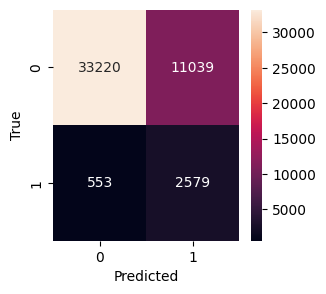

Test - Recall: 0.8234, F1: 0.3079, Accuracy: 0.7554
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.59it/s]


Epoch 153/200, Loss: 0.3519


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.85it/s]


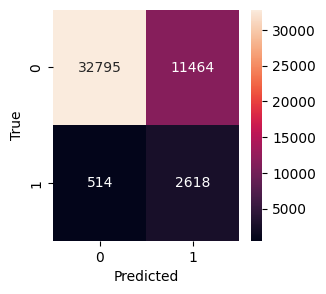

Test - Recall: 0.8359, F1: 0.3042, Accuracy: 0.7473
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.10it/s]


Epoch 154/200, Loss: 0.3501


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.39it/s]


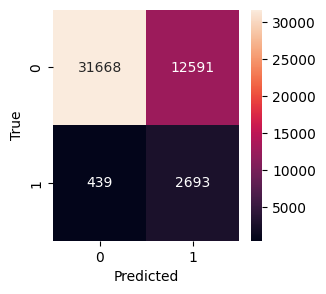

Test - Recall: 0.8598, F1: 0.2925, Accuracy: 0.7251
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.47it/s]


Epoch 155/200, Loss: 0.3546


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.67it/s]


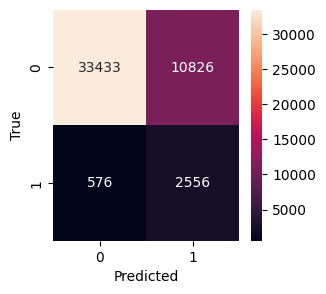

Test - Recall: 0.8161, F1: 0.3096, Accuracy: 0.7594
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.26it/s]


Epoch 156/200, Loss: 0.3501


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 102.64it/s]


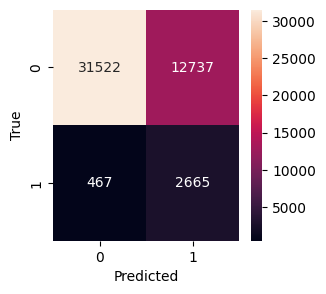

Test - Recall: 0.8509, F1: 0.2876, Accuracy: 0.7214
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.86it/s]


Epoch 157/200, Loss: 0.3538


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.46it/s]


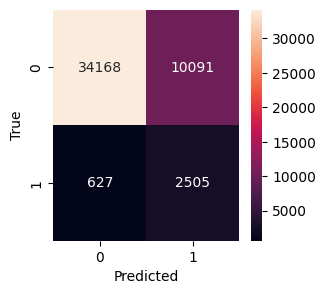

Test - Recall: 0.7998, F1: 0.3185, Accuracy: 0.7738
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.70it/s]


Epoch 158/200, Loss: 0.3497


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.31it/s]


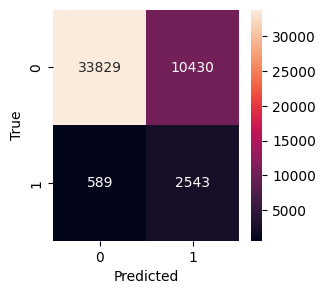

Test - Recall: 0.8119, F1: 0.3158, Accuracy: 0.7675
✅ Saved new best model at Epoch 158 with Score: 0.7891
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.55it/s]


Epoch 159/200, Loss: 0.3498


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.61it/s]


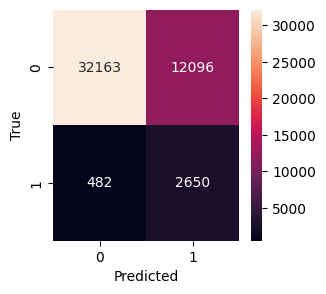

Test - Recall: 0.8461, F1: 0.2965, Accuracy: 0.7346
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 29.90it/s]


Epoch 160/200, Loss: 0.3478


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.75it/s]


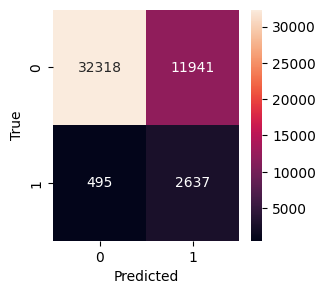

Test - Recall: 0.8420, F1: 0.2978, Accuracy: 0.7376
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.28it/s]


Epoch 161/200, Loss: 0.3494


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.99it/s]


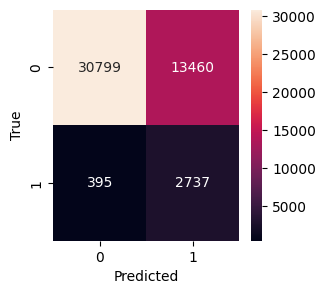

Test - Recall: 0.8739, F1: 0.2832, Accuracy: 0.7076
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.13it/s]


Epoch 162/200, Loss: 0.3510


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.79it/s]


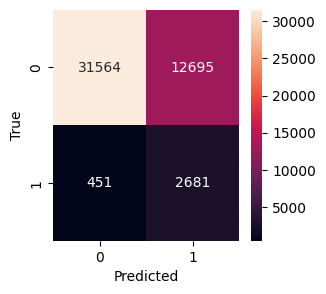

Test - Recall: 0.8560, F1: 0.2897, Accuracy: 0.7226
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.75it/s]


Epoch 163/200, Loss: 0.3465


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.37it/s]


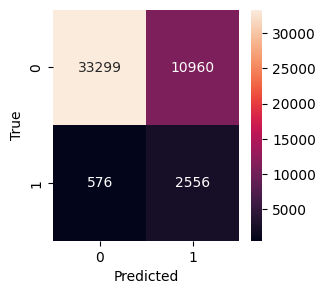

Test - Recall: 0.8161, F1: 0.3071, Accuracy: 0.7566
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.65it/s]


Epoch 164/200, Loss: 0.3513


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.60it/s]


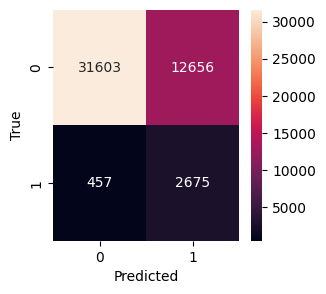

Test - Recall: 0.8541, F1: 0.2898, Accuracy: 0.7233
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.43it/s]


Epoch 165/200, Loss: 0.3476


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 111.20it/s]


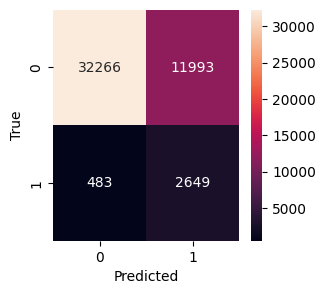

Test - Recall: 0.8458, F1: 0.2981, Accuracy: 0.7367
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.05it/s]


Epoch 166/200, Loss: 0.3471


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.15it/s]


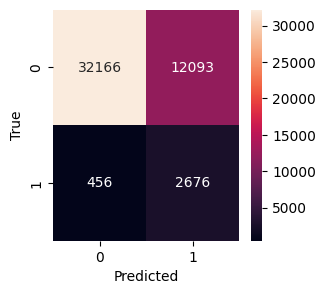

Test - Recall: 0.8544, F1: 0.2990, Accuracy: 0.7352
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.17it/s]


Epoch 167/200, Loss: 0.3482


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.93it/s]


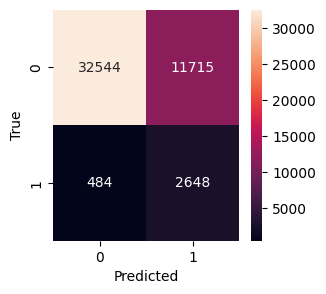

Test - Recall: 0.8455, F1: 0.3027, Accuracy: 0.7426
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.49it/s]


Epoch 168/200, Loss: 0.3442


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 111.58it/s]


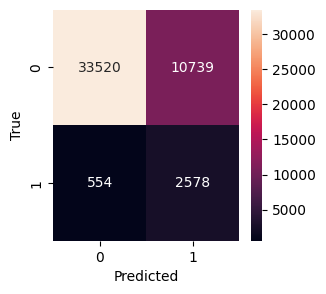

Test - Recall: 0.8231, F1: 0.3135, Accuracy: 0.7617
✅ Saved new best model at Epoch 168 with Score: 0.7912
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.74it/s]


Epoch 169/200, Loss: 0.3475


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.98it/s]


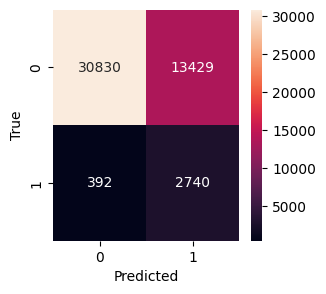

Test - Recall: 0.8748, F1: 0.2839, Accuracy: 0.7084
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.34it/s]


Epoch 170/200, Loss: 0.3467


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.37it/s]


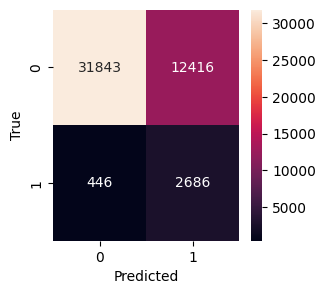

Test - Recall: 0.8576, F1: 0.2946, Accuracy: 0.7286
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.86it/s]


Epoch 171/200, Loss: 0.3449


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.53it/s]


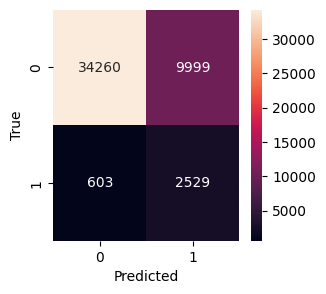

Test - Recall: 0.8075, F1: 0.3230, Accuracy: 0.7763
✅ Saved new best model at Epoch 171 with Score: 0.7916
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.24it/s]


Epoch 172/200, Loss: 0.3449


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.31it/s]


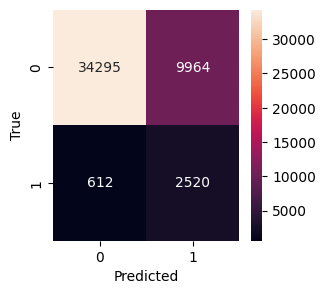

Test - Recall: 0.8046, F1: 0.3227, Accuracy: 0.7768
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.86it/s]


Epoch 173/200, Loss: 0.3443


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.19it/s]


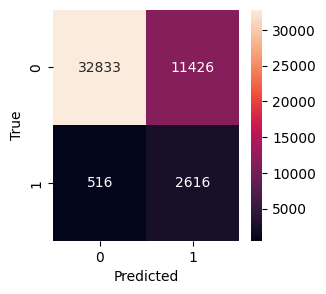

Test - Recall: 0.8352, F1: 0.3046, Accuracy: 0.7480
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.90it/s]


Epoch 174/200, Loss: 0.3453


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.37it/s]


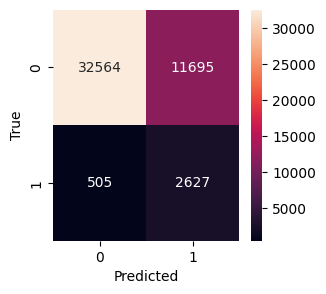

Test - Recall: 0.8388, F1: 0.3010, Accuracy: 0.7426
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.70it/s]


Epoch 175/200, Loss: 0.3451


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.49it/s]


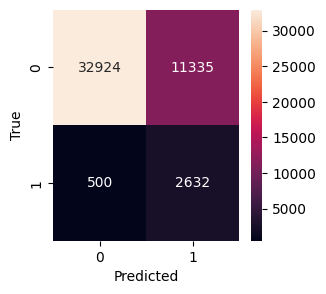

Test - Recall: 0.8404, F1: 0.3079, Accuracy: 0.7503
✅ Saved new best model at Epoch 175 with Score: 0.7928
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.66it/s]


Epoch 176/200, Loss: 0.3445


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.70it/s]


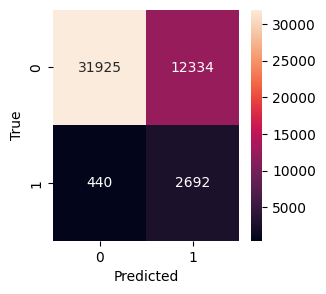

Test - Recall: 0.8595, F1: 0.2965, Accuracy: 0.7305
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.13it/s]


Epoch 177/200, Loss: 0.3426


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 104.96it/s]


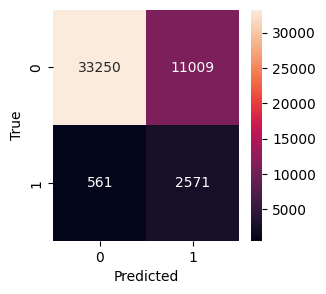

Test - Recall: 0.8209, F1: 0.3077, Accuracy: 0.7559
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.14it/s]


Epoch 178/200, Loss: 0.3448


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.77it/s]


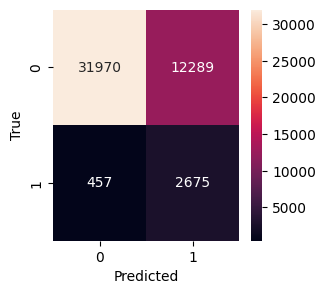

Test - Recall: 0.8541, F1: 0.2956, Accuracy: 0.7310
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.58it/s]


Epoch 179/200, Loss: 0.3422


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.62it/s]


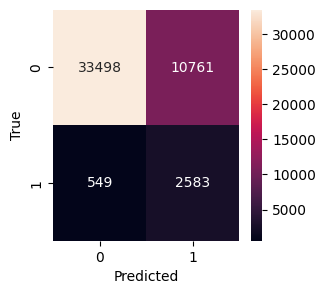

Test - Recall: 0.8247, F1: 0.3135, Accuracy: 0.7613
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.71it/s]


Epoch 180/200, Loss: 0.3422


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.81it/s]


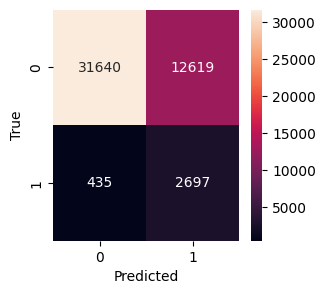

Test - Recall: 0.8611, F1: 0.2924, Accuracy: 0.7245
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.41it/s]


Epoch 181/200, Loss: 0.3436


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 110.32it/s]


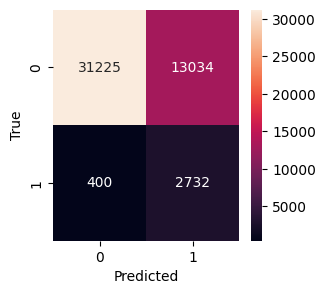

Test - Recall: 0.8723, F1: 0.2891, Accuracy: 0.7165
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.74it/s]


Epoch 182/200, Loss: 0.3436


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.57it/s]


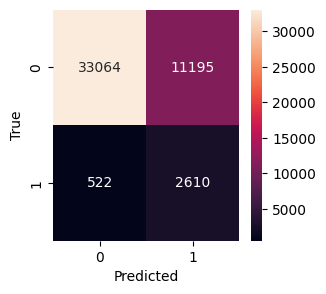

Test - Recall: 0.8333, F1: 0.3082, Accuracy: 0.7528
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.91it/s]


Epoch 183/200, Loss: 0.3395


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 110.08it/s]


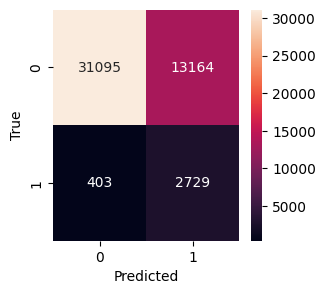

Test - Recall: 0.8713, F1: 0.2869, Accuracy: 0.7137
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.80it/s]


Epoch 184/200, Loss: 0.3452


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.25it/s]


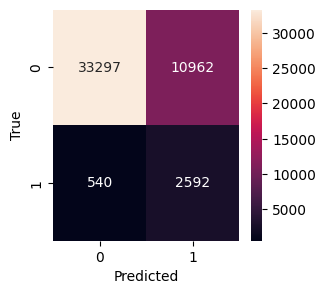

Test - Recall: 0.8276, F1: 0.3107, Accuracy: 0.7573
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.67it/s]


Epoch 185/200, Loss: 0.3429


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.34it/s]


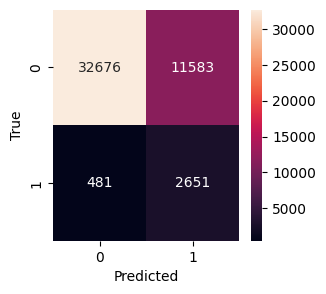

Test - Recall: 0.8464, F1: 0.3053, Accuracy: 0.7454
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 32.16it/s]


Epoch 186/200, Loss: 0.3420


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.70it/s]


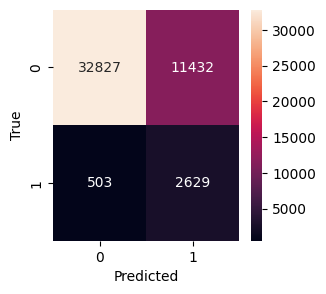

Test - Recall: 0.8394, F1: 0.3058, Accuracy: 0.7482
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.16it/s]


Epoch 187/200, Loss: 0.3424


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.79it/s]


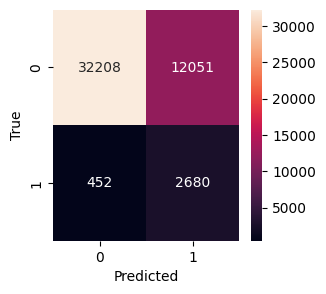

Test - Recall: 0.8557, F1: 0.3001, Accuracy: 0.7362
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.19it/s]


Epoch 188/200, Loss: 0.3418


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.01it/s]


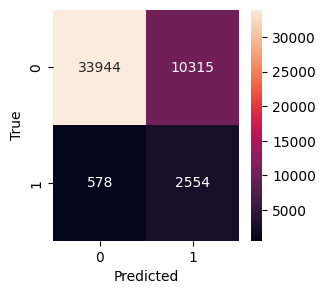

Test - Recall: 0.8155, F1: 0.3192, Accuracy: 0.7701
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.84it/s]


Epoch 189/200, Loss: 0.3396


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.23it/s]


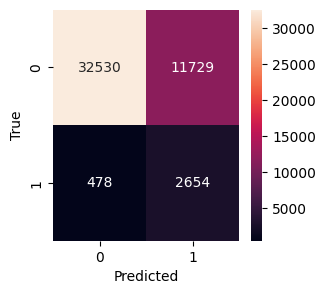

Test - Recall: 0.8474, F1: 0.3031, Accuracy: 0.7424
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.21it/s]


Epoch 190/200, Loss: 0.3406


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.77it/s]


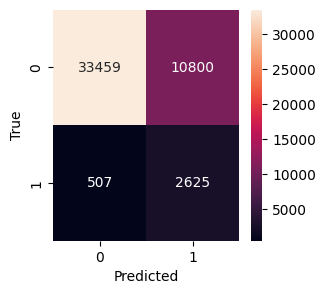

Test - Recall: 0.8381, F1: 0.3171, Accuracy: 0.7614
✅ Saved new best model at Epoch 190 with Score: 0.7979
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.61it/s]


Epoch 191/200, Loss: 0.3384


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 109.90it/s]


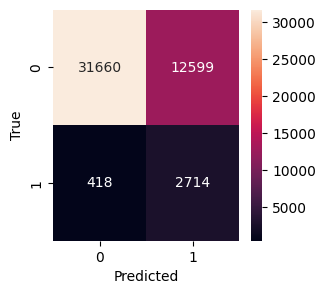

Test - Recall: 0.8665, F1: 0.2943, Accuracy: 0.7253
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 27.68it/s]


Epoch 192/200, Loss: 0.3381


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 103.97it/s]


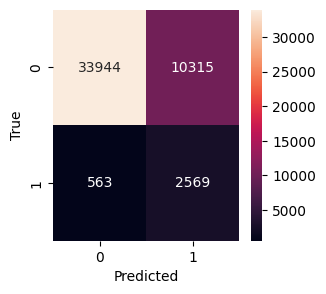

Test - Recall: 0.8202, F1: 0.3208, Accuracy: 0.7705
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.20it/s]


Epoch 193/200, Loss: 0.3414


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.63it/s]


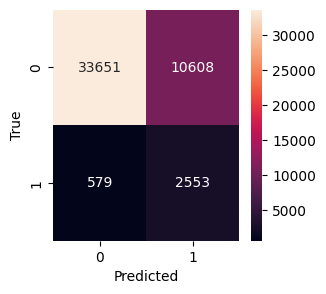

Test - Recall: 0.8151, F1: 0.3134, Accuracy: 0.7639
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.79it/s]


Epoch 194/200, Loss: 0.3408


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.49it/s]


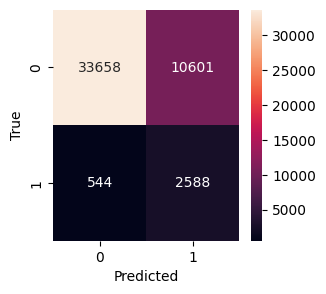

Test - Recall: 0.8263, F1: 0.3171, Accuracy: 0.7648
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.41it/s]


Epoch 195/200, Loss: 0.3368


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.10it/s]


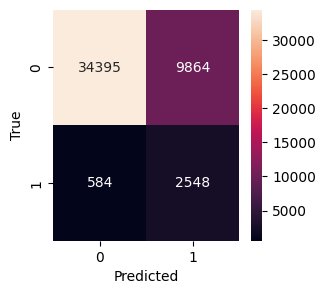

Test - Recall: 0.8135, F1: 0.3278, Accuracy: 0.7795
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.12it/s]


Epoch 196/200, Loss: 0.3379


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 105.35it/s]


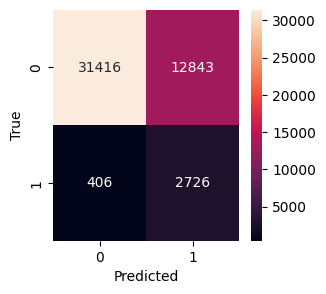

Test - Recall: 0.8704, F1: 0.2915, Accuracy: 0.7204
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.11it/s]


Epoch 197/200, Loss: 0.3423


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.24it/s]


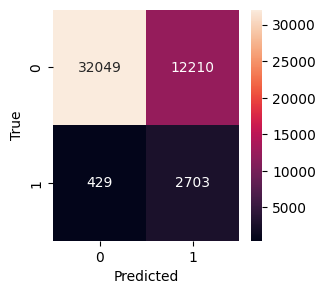

Test - Recall: 0.8630, F1: 0.2996, Accuracy: 0.7333
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 30.88it/s]


Epoch 198/200, Loss: 0.3390


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 106.95it/s]


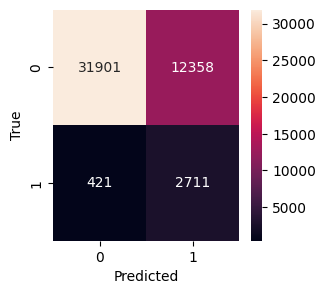

Test - Recall: 0.8656, F1: 0.2979, Accuracy: 0.7303
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.27it/s]


Epoch 199/200, Loss: 0.3386


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 107.51it/s]


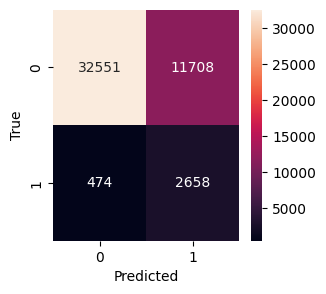

Test - Recall: 0.8487, F1: 0.3038, Accuracy: 0.7429
###################################################################################################################################


Training batches: 100%|██████████| 39/39 [00:01<00:00, 31.34it/s]


Epoch 200/200, Loss: 0.3362


Evaluating batches: 100%|██████████| 24/24 [00:00<00:00, 108.30it/s]


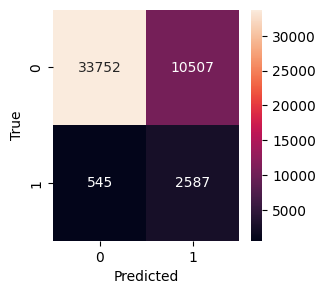

Test - Recall: 0.8260, F1: 0.3189, Accuracy: 0.7668
###################################################################################################################################


In [30]:
# Training function with HGTLoader
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training batches"):
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass on batch (HGTLoader returns a HeteroData object)
        out = model(batch)
        labels = batch['transaction'].is_laundering.to(dtype=torch.long, device=device)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Updated evaluation function with correct batching
def evaluate(model, data, test_mask, batch_size=2048):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_indices = test_mask.nonzero(as_tuple=True)[0]  # Indices of test transaction nodes
        num_test_samples = len(test_indices)
        
        for i in tqdm(range(0, num_test_samples, batch_size), desc="Evaluating batches"):
            batch_indices = test_indices[i:i + batch_size]  # Slice test transaction indices
            
            # Create subset dictionary for subgraph
            transaction_mask = torch.zeros(num_transactions, dtype=torch.bool, device=device)
            transaction_mask[batch_indices] = True
            
            # Include connected user nodes (1-hop neighbors)
            user_indices = set()
            for edge_type in data.edge_types:
                edge_index = data[edge_type].edge_index
                src, dst = edge_index[0], edge_index[1]
                if edge_type[0] == 'user':  # user -> transaction
                    mask = transaction_mask[dst]
                    user_indices.update(src[mask].tolist())
                elif edge_type[2] == 'user':  # transaction -> user
                    mask = transaction_mask[src]
                    user_indices.update(dst[mask].tolist())
            user_mask = torch.zeros(data['user'].x.shape[0], dtype=torch.bool, device=device)
            user_mask[list(user_indices)] = True
            
            # Subgraph with both node types
            subset_dict = {
                'transaction': transaction_mask,
                'user': user_mask
            }
            batch_data = data.subgraph(subset_dict)
            
            # Forward pass
            out = model(batch_data)
            preds = out.argmax(dim=1)
            labels = batch_data['transaction'].is_laundering.to(dtype=torch.long, device=device)
            all_preds.append(preds)
            all_labels.append(labels)
    
    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate metrics
    true_positives = (all_preds == 1) & (all_labels == 1)
    true_positives_sum = true_positives.sum().float()
    recall = true_positives_sum / all_labels.sum().float() if all_labels.sum() > 0 else 0.0
    precision = true_positives_sum / all_preds.sum().float() if all_preds.sum() > 0 else 0.0
    f1 = 2 * (recall * precision) / (recall + precision) if (recall + precision) > 0 else 0.0
    accuracy = (all_preds == all_labels).sum().float() / all_labels.size(0)
    
    cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return recall, f1, accuracy


num_epochs = 200

losses = []
recalls = []
f1s = []
accuracies = []

best_score = -1.0  # Custom score for saving best model
best_model_state = None

for epoch in range(num_epochs):
    loss = train(model, hgt_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
    losses.append(loss)
    
    recall, f1, accuracy = evaluate(model, data, test_mask)
    print(f"Test - Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)

    # Compute trade-off score (you can change this formula if needed)
    score = 2 * (recall * accuracy) / (recall + accuracy + 1e-8)  # Harmonic mean

    # Save model if score is best so far
    if score > best_score and accuracy>0.75:
        best_score = score
        best_model_state = model.state_dict()
        torch.save(best_model_state, '/kaggle/working/best_model.pth')
        print(f"✅ Saved new best model at Epoch {epoch+1} with Score: {score:.4f}")
    print("###################################################################################################################################")


Computing metrics batches: 100%|██████████| 24/24 [00:00<00:00, 90.55it/s]


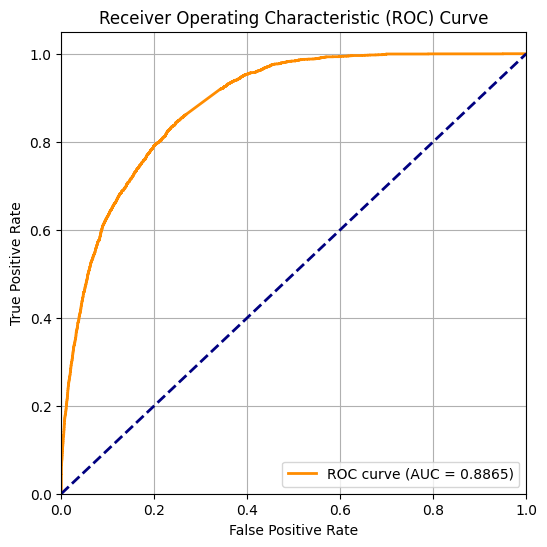

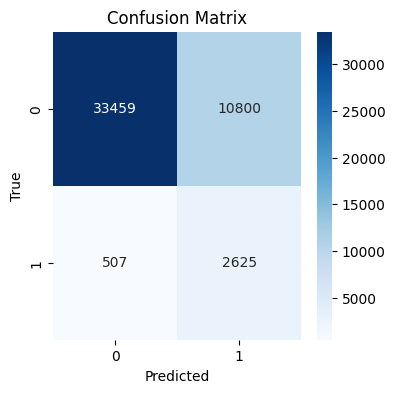

AUC Score: 0.8865
Recall: 0.8381
Accuracy: 0.7614
Score (Harmonic Mean of Recall and Accuracy): 0.7979


In [36]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

# Evaluate test set to get predicted probabilities and metrics
all_probs = []
all_preds = []
all_labels = []
batch_size = 2048  # Same as in evaluate function
num_transactions = data['transaction'].x.shape[0]

with torch.no_grad():
    test_indices = data['transaction'].test_mask.nonzero(as_tuple=True)[0]  # Indices of test transaction nodes
    num_test_samples = len(test_indices)
    
    for i in tqdm(range(0, num_test_samples, batch_size), desc="Computing metrics batches"):
        batch_indices = test_indices[i:i + batch_size]  # Slice test transaction indices
        
        # Create subset dictionary for subgraph
        transaction_mask = torch.zeros(num_transactions, dtype=torch.bool, device=device)
        transaction_mask[batch_indices] = True
        
        # Include connected user nodes (1-hop neighbors)
        user_indices = set()
        for edge_type in data.edge_types:
            edge_index = data[edge_type].edge_index
            src, dst = edge_index[0], edge_index[1]
            if edge_type[0] == 'user':  # user -> transaction
                mask = transaction_mask[dst]
                user_indices.update(src[mask].tolist())
            elif edge_type[2] == 'user':  # transaction -> user
                mask = transaction_mask[src]
                user_indices.update(dst[mask].tolist())
        user_mask = torch.zeros(data['user'].x.shape[0], dtype=torch.bool, device=device)
        user_mask[list(user_indices)] = True
        
        # Subgraph with both node types
        subset_dict = {
            'transaction': transaction_mask,
            'user': user_mask
        }
        batch_data = data.subgraph(subset_dict)
        
        # Forward pass to get logits
        out = model(batch_data)
        # Apply softmax to get probabilities, extract probability for class 1 (fraudulent)
        probs = F.softmax(out, dim=1)[:, 1]
        # Get predictions by taking the argmax
        preds = out.argmax(dim=1)
        labels = batch_data['transaction'].is_laundering.to(dtype=torch.long, device=device)
        
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate probabilities, predictions, and labels
all_probs = torch.cat(all_probs, dim=0).cpu().numpy()
all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Compute metrics
true_positives = (all_preds == all_labels) & (all_labels == 1)
true_positives_sum = true_positives.sum()
recall = true_positives_sum / all_labels.sum() if all_labels.sum() > 0 else 0.0
precision = true_positives_sum / all_preds.sum() if all_preds.sum() > 0 else 0.0
accuracy = (all_preds == all_labels).sum() / all_labels.shape[0]  # Fixed: use .shape[0] for NumPy array
score = 2 * (recall * accuracy) / (recall + accuracy + 1e-8)  # Harmonic mean, as in your script

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
print(f"AUC Score: {roc_auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Score (Harmonic Mean of Recall and Accuracy): {score:.4f}")

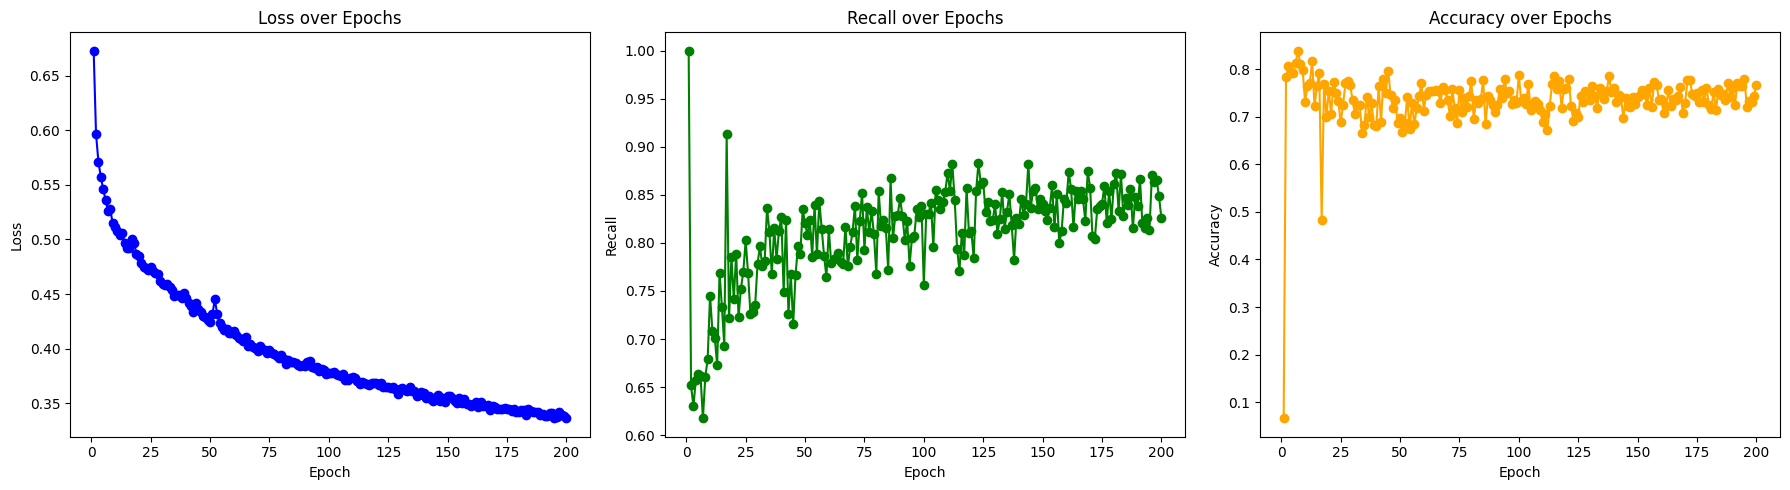

In [37]:
import matplotlib.pyplot as plt

# Convert all values to CPU and NumPy (if they're still tensors)
epochs = list(range(1, num_epochs + 1))
losses = [l.item() if torch.is_tensor(l) else l for l in losses]
recalls = [r.cpu().item() if torch.is_tensor(r) else r for r in recalls]
accuracies = [a.cpu().item() if torch.is_tensor(a) else a for a in accuracies]

# Plotting
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, marker='o', color='blue')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, recalls, marker='o', color='green')
plt.title("Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracies, marker='o', color='orange')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
